# I. Data Loading & Representation

## Necessary Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import missingno as msno # not pre installed in anaconda
import folium # not pre installed in anaconda 
import math

from pandas.api.types import is_numeric_dtype
from scipy.stats import ttest_ind
from matplotlib import pyplot

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

%matplotlib inline

In [2]:
# to have nice graphs
sns.set_style(style="darkgrid")
sns.set_context("poster")
plt.style.use('ggplot')

In [3]:
# to visualize whole dataframes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.width = 0

# Ressources Used:
- map: <br>
https://python-visualization.github.io/folium/quickstart.html <br>
https://france-geojson.gregoiredavid.fr/ -> to get geojson data of french departements
- predictiv algorithme: <br>
https://realpython.com/logistic-regression-python/  <br>
https://machinelearningmastery.com/calculate-feature-importance-with-python/

Warning :
This project uses librairies/packages wich are not pre-installed in Anaconda. Two solutions are provided, so that you can make work the code in the different notebooks:

1. You can simply install manually the two only packages we used which are not in the pre-installed Anadonda package, in your base environment or any virtual anaconda environment you want: <br>
a. Folium -
pip install folium <br>
b. Missingno -
pip install missingno
2. You can run in Anaconda prompt the following command: conda env create --name your_env_name --file=environment.yml

## Load Data

In [4]:
# Main dataset
data = pd.read_csv('project-24-files/dataset.csv')
# Additional information
df_contract = pd.read_csv('project-24-files/dataset_contract.csv')
df_club = pd.read_csv('project-24-files/dataset_CLUB.csv')
# Geographical information
df_city_adm = pd.read_csv('project-24-files/city_adm.csv')
df_city_loc = pd.read_csv('project-24-files/city_loc.csv')
df_city_pop = pd.read_csv('project-24-files/city_pop.csv')
df_dep = pd.read_csv('project-24-files/departments.csv')
df_reg = pd.read_csv('project-24-files/regions.csv')

# dataset for modelling 
df = pd.read_csv('project-24-files/model_data.csv', index_col='Key')

In [5]:
data.head()

key         f_name  LAST NAME  IS_STUDENT   sex  age_2020 degree   act  \
0    1  JEAN-FRANÇOIS      GUYON       False  Male        51  HD1_3  AT11   
1    2         DIDIER    BRUSCHI       False  Male        52  HD1_3  AT11   
2    3          ALAIN   LECUREUR       False  Male        56  HD1_3  AT11   
3    4        LUDOVIC  ROUSSIERE       False  Male        42  HD1_6  AT11   
4    5      SÉBASTIEN     BARDIN       False  Male        25  HD1_6  AT11   

  OCCUPATION_24 Insee_code Household_type Occupation_8  Outcome  
0       SPC-1-0      03184      typemr4.1         CSP1  success  
1       SPC-1-0      07042      typemr4.4         CSP1  success  
2       SPC-1-0      14365      typemr4.1         CSP1  success  
3       SPC-1-0      17328      typemr4.1         CSP1  success  
4       SPC-1-0      17442      typemr3.1         CSP1  success

## 1) Merge the main dataset with the Additional information variables (contract, club) and the geographical data

In [6]:
# 1st we are going to set the key as the index in all three dataframes (data, df_contract, df_club)
data.set_index('key', inplace=True)
df_contract.set_index('key', inplace=True)
df_club.set_index('key', inplace=True)

In [7]:
# join the three df based on key index
df_add_info = data.join(df_contract)
df_add_info = df_add_info.join(df_club)

In [8]:
# we add a column Outcome_stat where success is encoding by 1 and failure by 0,
# this will help us in performing some statistical analysis
df_add_info['Outcome_stat'] = np.where(df_add_info['Outcome'] == 'success', 1,
                                        0)

In [9]:
df_add_info.tail()

f_name LAST NAME  IS_STUDENT     sex  age_2020 degree   act  \
key                                                                   
9996   CHANTAL   PAROUTY       False  Female        64  HD0_1  AT24   
9997   JOSIANE   PINAULT       False  Female        73  HD1_9  AT25   
9998    CARMEN    MENARD       False  Female        70  HD1_3  AT25   
9999     DOLLY    LE BER       False  Female        76  HD0_2  AT21   
10000   DIDIER  GRIFFOIN       False    Male        61  HD1_3  AT25   

      OCCUPATION_24 Insee_code Household_type Occupation_8  Outcome contract  \
key                                                                            
9996        SPC-8-2      94059      typemr4.4         CSP8  success      NaN   
9997        SPC-8-2      94081      typemr3.2         CSP8  success      NaN   
9998        SPC-8-2      95280      typemr4.4         CSP8  success      NaN   
9999        SPC-8-2      95424      typemr1.2         CSP8  failure      NaN   
10000       SPC-8-2      95427      typemr1.1         CSP8  success      NaN   

      CLUB  Outcome_stat  
key                       
9996   NaN             1  
9997   NaN             1  
9998   NaN             1  
9999   NaN             0  
10000  NaN             1

Now we have a new dataframe containing all the basic information plus the additional information (contract, club)

We now want to add the geographical data to our main dataset. In order to do so we will use the "insee_code" to merge df_city_adm, df_city_loc, df_city_pop to the df_add_info dataframe. Then we will use the "dep" and "reg" variables to add the departements and region data to the complete dataset.

In [10]:
df_temp = pd.merge(df_city_adm, df_city_loc, on='Insee_code', how='outer')
df_city = pd.merge(df_temp, df_city_pop, on='Insee_code', how='outer') 

In [11]:
# add departements and region data to city data (to get data about the full administrative and geographical structure of France)
df_france = pd.merge(df_city, df_dep, on='dep', how='outer')
df_france = pd.merge(df_france, df_reg, on='reg', how='outer')

In [12]:
# Quick check of missing values
df_france.isna().sum()

Nom de la commune     0
Insee_code            0
City_type             0
dep                   0
X                     0
Y                     0
Lat                   0
long                  0
INHABITANTS           0
Nom du département    0
reg                   0
Nom de la région      0
dtype: int64

In [13]:
# total dataset concatenating the dataframe with additional informations and the dataframe with geographical information
df_total = pd.merge(df_add_info, df_france, on='Insee_code', how='inner')

In [14]:
df_total.columns

Index(['f_name', 'LAST NAME', 'IS_STUDENT', 'sex', 'age_2020', 'degree', 'act',
       'OCCUPATION_24', 'Insee_code', 'Household_type', 'Occupation_8',
       'Outcome', 'contract', 'CLUB', 'Outcome_stat', 'Nom de la commune',
       'City_type', 'dep', 'X', 'Y', 'Lat', 'long', 'INHABITANTS',
       'Nom du département', 'reg', 'Nom de la région'],
      dtype='object')

In [15]:
df_total.isna().sum()

f_name                   0
LAST NAME                0
IS_STUDENT               0
sex                      0
age_2020                 0
degree                   0
act                      0
OCCUPATION_24            0
Insee_code               0
Household_type           0
Occupation_8             0
Outcome                  0
contract              5126
CLUB                  8509
Outcome_stat             0
Nom de la commune        0
City_type                0
dep                      0
X                        0
Y                        0
Lat                      0
long                     0
INHABITANTS              0
Nom du département       0
reg                      0
Nom de la région         0
dtype: int64

Now that we have built a dataset containing all the variables at hand, we are concerned about dealing with the missing values.

## 2) Dealing with Missing values

### a) Contract variable

In [16]:
print('The total number of missing values in the "contract" variable is:',df_total['contract'].isna().sum())
print('Proportion of person with a missing contract in our dataset',
      (df_total['contract'].isna().sum() / df_total.shape[0]))

The total number of missing values in the "contract" variable is: 5126
Proportion of person with a missing contract in our dataset 0.5126


We have a lot of missing values for this variable. The way we deal with those missing values may have a big impact on the results of our analysis, so this process must be taken with care. 

We can first try to understand what could have caused those indidividuals to have a missing contract in the dataset:
* The individual is active and has a contract but his contract has been missed in the collection stage
* The individual is inactive and hence he has no working contract (retiree, housewife, student etc.)

A first step could be to **try to identify inactive individuals using the "act" variable (which describes the nature of the activity of the individual) and assign them a new category of the "contract" variable: inactive.**
We can then assume that the individuals left with a missing value in "contract" may be people for which the contract has not been properly registered in the collection process stage. Based on the number of observations in that case we can simply remove them of the dataset (if not too many) or try to identify their true contract using other variables (if they are too many).

If none of those techniques enables us to identify clearly the underlying aspect of the missing values, **we can also take those missing values as a category and rename if for instance "inactives or missing contracts or other"**. We could also remove all the observations with a missing value (but it might a bad idea since it would exclude inactives and other category of individuals from our sample).

#### i) Try to identify inactives among the observations with a missing "contract"

In [17]:
df_total.columns

Index(['f_name', 'LAST NAME', 'IS_STUDENT', 'sex', 'age_2020', 'degree', 'act',
       'OCCUPATION_24', 'Insee_code', 'Household_type', 'Occupation_8',
       'Outcome', 'contract', 'CLUB', 'Outcome_stat', 'Nom de la commune',
       'City_type', 'dep', 'X', 'Y', 'Lat', 'long', 'INHABITANTS',
       'Nom du département', 'reg', 'Nom de la région'],
      dtype='object')

useful variables in our investigation:
* IS_STUDENT
* act (très utile) inactifs:
    * (AT12","Chômeurs")
    * "AT21","Retraités ou préretraités"
    * AT22","Elèves, étudiants, stagiaires non rémunéré de 14 ans ou plus"
    * "AT23","Moins de 14 ans"
    * "AT24","Femmes ou hommes au foyer"
    * "AT25","Autres inactifs"
* Occupation_8 (retraités, Autres personnes sans activité professionelle)
* Household_type ("Famille principale composée d'un couple d’aucun 'actif ayant un emploi' -> chomeur ont il une catégorie dans 'contract' déja?)

<u>**Students:**</u>

In [18]:
print('proportion of individuals which are students and have a missing value in "contract":', 
      df_total.loc[df_total['IS_STUDENT'],'contract'].isna().sum() / len(df_total[df_total['IS_STUDENT']]))
print('Total amount of missing values of "contract" which are explained by the individual being a student so inacitve:', 
      df_total.loc[df_total['IS_STUDENT'],'contract'].isna().sum())

proportion of individuals which are students and have a missing value in "contract": 0.8225
Total amount of missing values of "contract" which are explained by the individual being a student so inacitve: 987


The first result is logic since most students are inactive. The second shows that already 1/4 of our missing values are easily explained using the **'IS_STUDENT' variable**. To precie our analysis and seperate inactive students from active students (with a contract) with can use the **"act" variable**.

In [19]:
nb_inact_stu_nan_contr = df_total.loc[(df_total['IS_STUDENT']) & (df_total['act'] == 'AT22'),'contract'].isna().sum()
print('number of inactive students with a missing "contract" value:', nb_inact_stu_nan_contr) 
       
print('proportion of inactive student with a nan value in "contract":',
      nb_inact_stu_nan_contr / len(df_total[(df_total['IS_STUDENT']) & (df_total['act'] == 'AT22')]))

number of inactive students with a missing "contract" value: 909
proportion of inactive student with a nan value in "contract": 1.0


We have found the number of students which are for sure inactive & which have a missing contract. Hence we can assign them the "inactive" category for the "contract" variable.

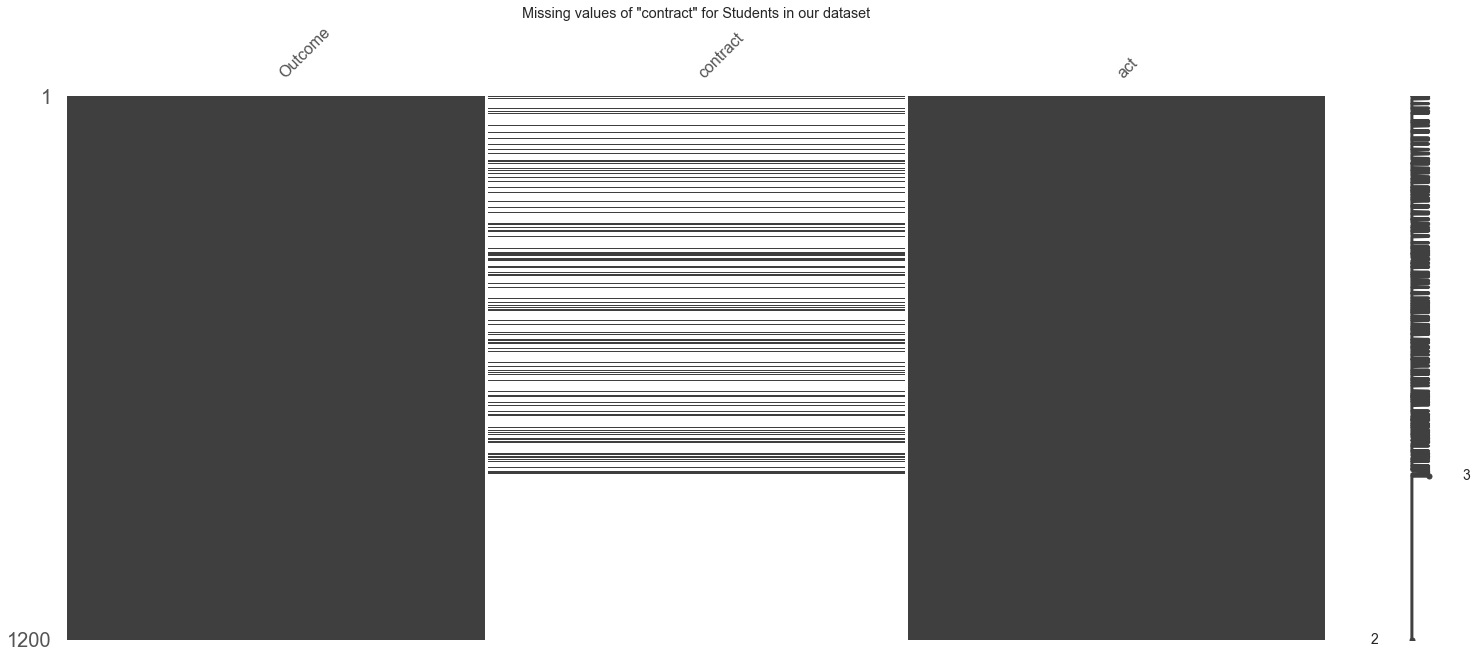

In [20]:
msno.matrix(df_total.loc[df_total['IS_STUDENT'], ['Outcome','contract', 'act']]) 
plt.title('Missing values of "contract" for Students in our dataset')
plt.show()

<u>**Housemen or Housewifes**</u>:

In [21]:
# use 'act' AT24 to spot Housewifes

In [22]:
nb_hwf_nan_contr = df_total.loc[df_total['act'] == 'AT24', 'contract'].isna().sum()
print('nber of housemen or housewifes with a missing value in "contract":', nb_hwf_nan_contr)
print('proportion of housemen or housewifes with a missing value in "contract":', 
      nb_hwf_nan_contr / len(df_total[df_total['act'] == 'AT24']))

nber of housemen or housewifes with a missing value in "contract": 261
proportion of housemen or housewifes with a missing value in "contract": 1.0


<u>**Retirees**</u>:

In [23]:
# let's use "Occupation_8" variable to spot them.

In [24]:
nb_ret_nan_contr = df_total[df_total['Occupation_8'] == 'CSP7']['contract'].isna().sum()
print('number of retirees with a missing value in "contract":', nb_ret_nan_contr)
print('proportion of retirees with a missing value in contract:', 
      nb_ret_nan_contr / len(df_total[df_total['Occupation_8'] == 'CSP7']))

number of retirees with a missing value in "contract": 2657
proportion of retirees with a missing value in contract: 1.0


Again we have identified inactive peoples in our sample dataset for which the nan value in "contract" must simply be replaced by a new category "inactive".

Hence using the information gathered through our triple analysis we can safely replace a bunch of missing values in the "contract" variable by creating a new category inactives. Once we have replaced those missing values, we will able to see how much nan's are left and try to fill the holes left.

In [25]:
# assigning the "inactive" category to inactive students in our dataset:
df_total.loc[(df_total['IS_STUDENT']) & (df_total['act'] == 'AT22'), 'contract'] = 'inactive'
# to housewifes:
df_total.loc[df_total['act'] == 'AT24', 'contract'] = 'inactive'
# to retirees
df_total.loc[df_total['Occupation_8'] == 'CSP7', 'contract'] = 'inactive'

<u>identify missing values left</u>

In [26]:
print('missing values left in "contract":', df_total['contract'].isna().sum())

missing values left in "contract": 1299


Those missing values are possibly:
* inactives that we have not spot yet (ex: Occupation_8 CSP8 "Autres personnes sans activité professionelle" ! chomeurs ou inactifs ? , act -> AT25 => "Autres inactifs", AT23 -> 'moins de 14 ans')
* unemployed (ex: occupation_8 CSP8 "Autres personnes sans activité professionelle" , act -> AT12 "chomeurs")
* active people for which the true contract has not been approprietly collected in the collection phase.
    * drop those observations (Solution adopted - limits the risk of miss-assignments)
    * try to identify their true contracts based on other variables and similitarities with other individuals in the sample with a defined contract.

In [27]:
# When looking at CSP8 "Autres personnes sans activité professionellle we need to seperate inactives from unemployed people 
# using act"
print(df_total[(df_total['Occupation_8'] == 'CSP8') & df_total['contract'].isna()]['act'].value_counts())
print('\namong CSP8 personnes with a nan in "contract":\n 444 are other inactives  \n 102 are unemployed')

AT25    444
AT12    102
AT21     36
AT22      9
Name: act, dtype: int64

among CSP8 personnes with a nan in "contract":
 444 are other inactives  
 102 are unemployed


In [28]:
df_total[df_total['act'] == 'AT25']['contract'].isna().sum()

444

In [29]:
# spot childrens in dataset
df_total[df_total['act'] == 'AT23']['contract'].isna().sum()

0

In [30]:
# unemployed 
df_total[df_total['act'] == 'AT12']['contract'].isna().sum()

810

Using CSP8 of 'Occupation_8' and 'AT12' of the variable act we can spot the status of the last individuals with a missing value in "contract" which are other inactive people or unemployed people. Let's assign them to a category for the "contract variable".

In [31]:
# assign "unemployed" category to the "contract" variable for people wich are unemployed
df_total.loc[df_total['act'] == 'AT12', 'contract'] = 'unemployed'
# assign "inactive" category to the "contract" variable for the last inactive people of the sample
df_total.loc[df_total['act'] == 'AT25', 'contract'] = 'inactive'

<u>Look at the last missing values</u>

In [32]:
df_total['contract'].isna().sum()

45

In [33]:
df_total[df_total['contract'].isna()]

f_name     LAST NAME  IS_STUDENT     sex  age_2020 degree  \
446           MONIQUE        ALGOUD       False  Female        71  HD1_1   
1845            EDITH       HERMAND       False  Female        83  HD0_2   
2130           ANDRÉE    THIELEMANS       False  Female        87  HD1_1   
2231         GERMAINE        MARTIN       False  Female        93  HD1_3   
2232         DANIELLE      DELANNEY       False  Female        73  HD0_2   
2239            BILEL      JAWORSKI       False    Male        21  HD0_2   
2315           DORINE      CHAMPION       False  Female        17  HD1_2   
2770         ROSELINE        BONNET       False  Female        71  HD0_2   
3159         REJEANNE         CADOT       False  Female        89  HD1_1   
3517            MARIE       CANIVET       False  Female        82  HD1_2   
3844             INÈS  LAGRANDCOURT       False  Female        90  HD1_7   
3981            KAMIL           FEY       False    Male        15  HD0_2   
4010           JEANNE      RAMILLON       False  Female        97  HD1_3   
5579          YOLANDE        LESAGE       False  Female        79  HD1_1   
5737             ANNE      FIGUERES       False  Female        66  HD0_2   
5751            DOLLY        LE BER       False  Female        76  HD0_2   
6596             PAUL         KIRCH       False    Male        16  HD1_2   
6851          COLETTE      BORRELLY       False  Female        72  HD0_1   
7216          MONIQUE        CHALUS       False  Female        71  HD0_2   
7347         MEDERICK          ROME       False    Male        17  HD1_2   
7696           RÉGINE        PALUCH       False  Female        79  HD1_2   
8189         LUDIVINE     BOISSINOT       False  Female        26  HD1_4   
8523             ERIC       SCACCIA       False    Male        50  HD0_1   
8932          AUGUSTA       DUTHOIT       False  Female        98  HD0_3   
9356            HENRI        CHEVET       False    Male        87  HD0_2   
9470          MAVRICK       TASSARD       False    Male        18  HD1_2   
9561            KÉVIN       REYNAUD       False    Male        21  HD0_1   
9580           ARNAUD    BAZZANELLA       False    Male        28  HD1_4   
9609          LILIANE        BOUREE       False  Female        70  HD1_3   
9941          COLETTE     PANHALEUX       False  Female        72  HD1_1   
9943        CHRISTIAN          GABY       False    Male        74  HD0_1   
9945         PAULETTE         RABOT       False  Female        82  HD0_1   
9946           DENISE        LAMBIN       False  Female        84  HD1_1   
9951            MARIA     BURGUNTER       False  Female        78  HD0_2   
9959             SUZY      VILLETTE       False  Female        68  HD1_3   
9960         JEANNINE        SECHER       False  Female        88  HD0_3   
9963           CLAUDE         FABRE       False    Male        73  HD1_3   
9967          MICHÈLE      DIASCORN       False  Female        72  HD1_1   
9975            MARIE        MOUSSE       False  Female        94  HD0_1   
9976  MARIE-FRANÇOISE        CADEAU       False  Female        67  HD0_2   
9979           ODETTE        CAROFF       False  Female        87  HD1_1   
9980       JACQUELINE       GRONDIN       False  Female        83  HD1_3   
9988          EVELINE       RENAULT       False  Female        70  HD1_4   
9992         MARCELLE        HABOLD       False  Female        87  HD1_1   
9997        CLAUDETTE       DODEMAN       False  Female        80  HD0_2   

       act OCCUPATION_24 Insee_code Household_type Occupation_8  Outcome  \
446   AT21       SPC-8-2      76540      typemr1.2         CSP8  success   
1845  AT21       SPC-8-2      68224      typemr1.2         CSP8  success   
2130  AT21       SPC-8-2      2A004      typemr1.2         CSP8  failure   
2231  AT21       SPC-8-2      59183      typemr1.2         CSP8  success   
2232  AT21       SPC-8-2      59183      typemr4.4         CSP8  success   
2239  AT22       SPC-8-2      59295      typemr4.4         CSP

Having a quick look to those observations we notice that those people our either retirees or young adults which are doing doing a non paying internship but are not students, so we can simply assign them to the "inactive" category.

In [34]:
df_total.loc[df_total['contract'].isna(), 'contract'] = 'inactive'

In [35]:
df_total['contract'].isna().sum()

0

### b) Club variable

NB: These are only sport clubs

In [36]:
df_total['CLUB'].isna().sum()

8509

The most plausible explanation for missing values in CLUB is that the people don't belong to any club.

In [37]:
print('average age of people belonging to a sport club:', df_total[~df_total['CLUB'].isna()]['age_2020'].mean())

average age of people belonging to a sport club: 40.179745137491615


In [38]:
print('average age of people not belonging to a sport club:',df_total[df_total['CLUB'].isna()]['age_2020'].mean())

average age of people not belonging to a sport club: 50.36502526736397


In [39]:
print('number of different sport clubs:',len(df_total['CLUB'].unique()))

number of different sport clubs: 84


In [40]:
df_total['CLUB'].value_counts()[:10]

fede111    191
fede123     94
fede109     85
fede132     77
fede402     75
fede604     66
fede105     55
fede242     48
fede413     33
fede245     33
Name: CLUB, dtype: int64

Hence a good way to deal with missing values of 'CLUB' as well as to reencode the variable to make it clearer could be to transform the variable 'CLUB' into a boolean variable 'IS_CLUB' 1: belongs to a club, 0: don't belong to a club.

In [41]:
df_total['IS_CLUB'] = np.where(df_total['CLUB'].isna(), False, True)
del df_total['CLUB']

In [42]:
df_total.columns

Index(['f_name', 'LAST NAME', 'IS_STUDENT', 'sex', 'age_2020', 'degree', 'act',
       'OCCUPATION_24', 'Insee_code', 'Household_type', 'Occupation_8',
       'Outcome', 'contract', 'Outcome_stat', 'Nom de la commune', 'City_type',
       'dep', 'X', 'Y', 'Lat', 'long', 'INHABITANTS', 'Nom du département',
       'reg', 'Nom de la région', 'IS_CLUB'],
      dtype='object')

## 3) Variable Encoding

In [43]:
# create a new dataframes where variables have been reencoded
df_encode = df_total.copy()

In [44]:
df_encode.head()

f_name  LAST NAME  IS_STUDENT   sex  age_2020 degree   act  \
0  JEAN-FRANÇOIS      GUYON       False  Male        51  HD1_3  AT11   
1        THIERRY   GIUSEPPI       False  Male        52  HD1_3  AT11   
2         DIDIER    BRUSCHI       False  Male        52  HD1_3  AT11   
3          ALAIN   LECUREUR       False  Male        56  HD1_3  AT11   
4        LUDOVIC  ROUSSIERE       False  Male        42  HD1_6  AT11   

  OCCUPATION_24 Insee_code Household_type Occupation_8  Outcome    contract  \
0       SPC-1-0      03184      typemr4.1         CSP1  success  contrat2|1   
1       SPC-4-8      03184      typemr1.1         CSP4  failure  contrat1|6   
2       SPC-1-0      07042      typemr4.4         CSP1  success  contrat2|1   
3       SPC-1-0      14365      typemr4.1         CSP1  success  contrat2|2   
4       SPC-1-0      17328      typemr4.1         CSP1  success  contrat2|1   

   Outcome_stat       Nom de la commune         City_type dep              X  \
0             1                Montilly    Commune simple  03  718372.600841   
1             0                Montilly    Commune simple  03  718372.600841   
2             1      Bourg-Saint-Andéol  Chef-lieu canton  07  828572.584085   
3             1            Lion-sur-Mer    Commune simple  14  457533.074558   
4             1  Saint-Fort-sur-Gironde    Commune simple  17  409213.988829   

              Y        Lat      long  INHABITANTS Nom du département  reg  \
0  6.612303e+06  46.610529  3.240057          540             Allier   84   
1  6.612303e+06  46.610529  3.240057          540             Allier   84   
2  6.366208e+06  44.383087  4.613984         7453            Ardèche   84   
3  6.916360e+06  49.300770 -0.333955         2480           Calvados   28   
4  6.491559e+06  45.461785 -0.722254          913  Charente-Maritime   75   

       Nom de la région  IS_CLUB  
0  Auvergne-Rhône-Alpes    False  
1  Auvergne-Rhône-Alpes    False  
2  Auvergne-Rhône-Alpes     True  
3             Normandie    False  
4    Nouvelle-Aquitaine    False

In [45]:
# degree 
# act
# Household_type
# Occupation_8
# contract -> reencode for clarity + recategorize

### i) Rename categories to have more explicit nominations

In [46]:
# Occupation_8
l_original_occ = list(df_total['Occupation_8'].unique())
l_new_occ = ['Agriculteurs exploitants', "Professions Intermédiaires", "Artisans commercants et chefs d'entreprise",
             "Ouvriers", "Retraités", "Autres personnes sans activité professionnelle", "Cadres et professions intellectuelles supérieures", "Employés"]
df_encode['Occupation_8'].replace(to_replace=l_original_occ, value=l_new_occ, inplace=True)

In [47]:
# act
l_origin_act = list(df_total['act'].unique())
l_origin_act = [x for x in sorted(l_origin_act)]
l_new_occ = ["Actifs ayant un emploi, y compris sous apprentissage ou en stage rémunéré.", 
             "Chômeurs", "Retratés ou préretraités", "Elèves, étudiants, stagiaires non rémunéré de 14 ans ou plus",
             "Femmes ou hommes au foyer", "Autres inactifs"]
df_encode['act'].replace(to_replace=l_origin_act, value=l_new_occ, inplace=True)

In [48]:
# Household_type
l_origin_hous = list(df_total['Household_type'].unique())
l_origin_hous = [x for x in sorted(l_origin_hous)]
l_new_hous = ['Homme vivant seul', 'Femme vivant seule', 'Plusieurs personnes sans famille', 'Famille monoparentale homme',
              'Famille monoparentale femme', 'Famille avec couple de deux actifs en emploi', 
              "Famille ou seul homme à le statut d'actif en emploi", "Famille ou seule femme à le statut d'actif en emploi",
              "Famille ou aucun à le statut d'actif en emploi"]
df_encode['Household_type'].replace(to_replace=l_origin_hous, value=l_new_hous, inplace=True)

In [49]:
# contract
old_contract_names = ["contrat1|1", "contrat1|2", "contrat1|3", "contrat1|4",
                      "contrat1|5", "contrat1|6", "contrat2|1", "contrat2|2",
                      "contrat2|3"]
new_contract_names = ['apprentissage ou professionalisation', 'intérimaire',
                      'emplois aidés', 'stagiaire', 'autre à durée limitée',
                      'CDI ou fonctionnaire', 'Indépendants', 'Employeurs',
                      'Aides familiaux']
df_encode['contract'].replace(to_replace=old_contract_names, 
                                value=new_contract_names,
                                inplace=True)

In [50]:
# degree
l_origin_degree = list(df_total['degree'].unique())
l_origin_degree = [x for x in sorted(l_origin_degree)]
l_new_degree = ["Pas de scolarité", "aucun diplôme primaire", "aucun diplôme collège", "CEP", "Brevet des collèges",
                "CAP, BEP ou diplôme de niveau équivalent", 
                "Baccalauréat général ou technologique, brevet supérieur, capacité en droit, DAEU, ESEU",
                "Baccalauréat ou brevet professionnel, diplôme équivalent", "BAC+2", "BAC+3 ou BAC+4", "BAC+5",
                "Doctorat de recherche"]
df_encode['degree'].replace(to_replace=l_origin_degree, value=l_new_degree, inplace=True)

In [51]:
df_encode['degree'].value_counts()

CAP, BEP ou diplôme de niveau équivalent                                                  2225
Baccalauréat général ou technologique, brevet supérieur, capacité en droit, DAEU, ESEU    1077
BAC+2                                                                                     1047
Brevet des collèges                                                                        905
BAC+5                                                                                      862
BAC+3 ou BAC+4                                                                             840
aucun diplôme collège                                                                      755
Baccalauréat ou brevet professionnel, diplôme équivalent                                   736
CEP                                                                                        719
aucun diplôme primaire                                                                     542
Pas de scolarité                                  

### ii) Regroup categories to get more insighful variables

<u>**contract**</u>

In [52]:
df_encode['contract'].value_counts()

inactive                                4316
CDI ou fonctionnaire                    3669
unemployed                               810
autre à durée limitée                    389
Indépendants                             304
Employeurs                               256
apprentissage ou professionalisation     101
intérimaire                               85
emplois aidés                             45
stagiaire                                 17
Aides familiaux                            8
Name: contract, dtype: int64

In [53]:
l_outsiders = ['stagiaire', 'intérimaire', 'emplois aidés', 
               'autre à durée limitée', 'apprentissage ou professionalisation', 'unemployed']
l_insiders = ['CDI ou fonctionnaire']
l_independants = ['Indépendants', 'Employeurs', 'Aides familiaux']

In [54]:
# reencode contract variable by replacing the old sub-categories by the 
# new categories

df_encode['contract'].replace(to_replace=l_outsiders, value='outsiders',
                               inplace=True)
df_encode['contract'].replace(to_replace=l_insiders, value='insiders',
                               inplace=True)
df_encode['contract'].replace(to_replace=l_independants, value='independants',
                               inplace=True)
df_encode['contract'].replace(to_replace='inactive', value='no contrat', inplace=True)

In [55]:
df_encode['contract'].value_counts()

no contrat      4316
insiders        3669
outsiders       1447
independants     568
Name: contract, dtype: int64

<u>**household type**</u>

In [56]:
df_encode['Household_type'].value_counts()

Famille avec couple de deux actifs en emploi            3342
Famille ou aucun à le statut d'actif en emploi          1933
Femme vivant seule                                      1156
Famille ou seul homme à le statut d'actif en emploi      932
Homme vivant seul                                        852
Famille monoparentale femme                              767
Famille ou seule femme à le statut d'actif en emploi     583
Plusieurs personnes sans famille                         243
Famille monoparentale homme                              192
Name: Household_type, dtype: int64

In [57]:
l_celib = ['Homme vivant seul', 'Femme vivant seule']
l_coloc = ['Plusieurs personnes sans famille']
l_mono_fam = ['Famille monoparentale femme', 'Famille monoparentale homme']
l_famille = ['Famille avec couple de deux actifs en emploi', "Famille ou aucun à le statut d'actif en emploi",
             "Famille ou seule femme à le statut d'actif en emploi", "Famille ou seul homme à le statut d'actif en emploi"]

df_encode['Household_type'].replace(to_replace=l_celib, value='célibataire', inplace=True)
df_encode['Household_type'].replace(l_coloc, 'colocataire', inplace=True)
df_encode['Household_type'].replace(l_mono_fam, 'famille monoparentale', inplace=True)
df_encode['Household_type'].replace(l_famille, 'famille', inplace=True)

In [58]:
df_encode['Household_type'].value_counts()

famille                  6790
célibataire              2008
famille monoparentale     959
colocataire               243
Name: Household_type, dtype: int64

<u>**degree**</u>

In [59]:
df_encode['degree'].value_counts()

CAP, BEP ou diplôme de niveau équivalent                                                  2225
Baccalauréat général ou technologique, brevet supérieur, capacité en droit, DAEU, ESEU    1077
BAC+2                                                                                     1047
Brevet des collèges                                                                        905
BAC+5                                                                                      862
BAC+3 ou BAC+4                                                                             840
aucun diplôme collège                                                                      755
Baccalauréat ou brevet professionnel, diplôme équivalent                                   736
CEP                                                                                        719
aucun diplôme primaire                                                                     542
Pas de scolarité                                  

We create new categories:
* sans diplome: "Pas de scolarité", "aucun diplôme primaire", "aucun diplôme collège"
* diplôme inférieur au baccalauréat: "CEP", "Brevet des collèges", "CAP, BEP ou diplôme de niveau équivalent"
* Baccalauréat général ou technologique, diplôme équivalent : "Baccalauréat général ou technologique, brevet supérieur, capacité en droit, DAEU, ESEU"
* Baccalauréat professionnel, diplôme équivalent: "Baccalauréat ou brevet professionel, diplôme équivalent"
* BAC +2
* BAC +3 ou BAC+4
* BAC+5
* Doctorat de recherche


In [60]:
# categories we need to rename or regroup
l_sans_diplome = ['Pas de scolarité', 'aucun diplôme primaire', 'aucun diplôme collège']
l_dipl_inf_bac = ['CEP', 'Brevet des collèges', "CAP, BEP ou diplôme de niveau équivalent"]
l_bac_gen_tech = ['Baccalauréat général ou technologique, brevet supérieur, capacité en droit, DAEU, ESEU']

df_encode['degree'].replace(l_sans_diplome, "sans diplôme", inplace=True)
df_encode['degree'].replace(l_dipl_inf_bac, 'diplôme inférieur au baccalauréat', inplace=True)
df_encode['degree'].replace(l_bac_gen_tech, 'Baccalauréat général ou technologique, diplôme équivalent', inplace=True)

df_encode['degree'].value_counts()

diplôme inférieur au baccalauréat                            3849
sans diplôme                                                 1524
Baccalauréat général ou technologique, diplôme équivalent    1077
BAC+2                                                        1047
BAC+5                                                         862
BAC+3 ou BAC+4                                                840
Baccalauréat ou brevet professionnel, diplôme équivalent      736
Doctorat de recherche                                          65
Name: degree, dtype: int64

regroupe HD0_1, HD0_2, HD0_3; -> sans diplome
HD1_1, HD1_2, HD1_3 -> diplome inférieur au bac
le reste on regroupe pas 

In [61]:
df_encode.head(3)

f_name LAST NAME  IS_STUDENT   sex  age_2020  \
0  JEAN-FRANÇOIS     GUYON       False  Male        51   
1        THIERRY  GIUSEPPI       False  Male        52   
2         DIDIER   BRUSCHI       False  Male        52   

                              degree  \
0  diplôme inférieur au baccalauréat   
1  diplôme inférieur au baccalauréat   
2  diplôme inférieur au baccalauréat   

                                                 act OCCUPATION_24 Insee_code  \
0  Actifs ayant un emploi, y compris sous apprent...       SPC-1-0      03184   
1  Actifs ayant un emploi, y compris sous apprent...       SPC-4-8      03184   
2  Actifs ayant un emploi, y compris sous apprent...       SPC-1-0      07042   

  Household_type                Occupation_8  Outcome      contract  \
0        famille    Agriculteurs exploitants  success  independants   
1    célibataire  Professions Intermédiaires  failure      insiders   
2        famille    Agriculteurs exploitants  success  independants   

   Outcome_stat   Nom de la commune         City_type dep              X  \
0             1            Montilly    Commune simple  03  718372.600841   
1             0            Montilly    Commune simple  03  718372.600841   
2             1  Bourg-Saint-Andéol  Chef-lieu canton  07  828572.584085   

              Y        Lat      long  INHABITANTS Nom du département  reg  \
0  6.612303e+06  46.610529  3.240057          540             Allier   84   
1  6.612303e+06  46.610529  3.240057          540             Allier   84   
2  6.366208e+06  44.383087  4.613984         7453            Ardèche   84   

       Nom de la région  IS_CLUB  
0  Auvergne-Rhône-Alpes    False  
1  Auvergne-Rhône-Alpes    False  
2  Auvergne-Rhône-Alpes     True

#### Reencoding of the arrondissements of the bigest cities

In [62]:
Paris= ['Paris 1er arrondissement','Paris 15e arrondissement','Paris 18e arrondissement','Paris 19e arrondissement','Paris 20e arrondissement','Paris 16e arrondissement','Paris 17e arrondissement','Paris 18e arrondissement', 'Paris 2e arrondissement', 'Paris 3e arrondissement', 'Paris 4e arrondissement','Paris 5e arrondissement','Paris 6e arrondissement','Paris 7e arrondissement','Paris 8e arrondissement','Paris 9e arrondissement','Paris 10e arrondissement','Paris 11e arrondissement','Paris 12e arrondissement','Paris 13e arrondissement','Paris 14e arrondissement']
Lyon=['Lyon 1er arrondissement','Lyon 2e arrondissement','Lyon 3e arrondissement','Lyon 4e arrondissement','Lyon 5e arrondissement','Lyon 6e arrondissement','Lyon 7e arrondissement','Lyon 8e arrondissement','Lyon 9e arrondissement']
Marseille=['Marseille 1er arrondissement','Marseille 2e arrondissement','Marseille 3e arrondissement','Marseille 4e arrondissement','Marseille 5e arrondissement','Marseille 5e arrondissement','Marseille 6e arrondissement', 'Marseille 7e arrondissment','Marseille 8e arrondissment','Marseille 9e arrondissement','Marseille 10e arrondissement','Marseille 11e arrondissement', 'Marseille 12e arrondissement','Marseille 13e arrondissement','Marseille 14e arrondissement','Marseille 15e arrondissement']


df_encode['Nom de la commune'].replace(to_replace=Paris, value='Paris',
                               inplace=True)
df_encode['Nom de la commune'].replace(to_replace=Lyon, value='Lyon',
                               inplace=True)
df_encode['Nom de la commune'].replace(to_replace=Marseille, value='Marseille',
                               inplace=True)



In [63]:
# We replace inhabitants value of arrondissement of paris by the total population of paris
df_encode.loc[df_encode['Nom de la commune'].str.startswith('Paris'), 'INHABITANTS'] = 1925548

In [64]:
#we do the same for marseille
df_encode.loc[df_encode['Nom de la commune'].str.startswith('Lyon'), 'INHABITANTS'] = 514707

In [65]:
#we do the same for lyon
df_encode.loc[df_encode['Nom de la commune'].str.startswith('Marseille'), 'INHABITANTS'] = 686370

### iii) Modify type of variables 

In [66]:
# we change the type of categorical data to the Pandas categories type
# we identify categorical data for which we have less than 100 unique different values (to capture departements as a categorical 
# data)

In [67]:
for col_name in df_encode.columns:
    # spot categorical variables but careful we don't want to change the category of boolean variables
    if (len(df_encode[col_name].unique()) <= 100) and (len(df_encode[col_name].unique()) > 2):
        df_encode[col_name] = df_encode[col_name].astype('category')

# manual rectifications
df_encode['Outcome_stat'] = df_encode['Outcome_stat'].astype('bool')
df_encode['sex'] = df_encode['sex'].astype('category')
df_encode['Outcome'] = df_encode['Outcome'].astype('category')

In [68]:
# we do the same fo the dataframe containing administrative and geographical data of France
for col_name in df_france.columns:
    if (len(df_encode[col_name].unique()) <= 100) and (len(df_encode[col_name].unique()) > 2):
        df_france[col_name] = df_france[col_name].astype('category')

In [69]:
df_encode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   f_name              10000 non-null  object  
 1   LAST NAME           10000 non-null  object  
 2   IS_STUDENT          10000 non-null  bool    
 3   sex                 10000 non-null  category
 4   age_2020            10000 non-null  category
 5   degree              10000 non-null  category
 6   act                 10000 non-null  category
 7   OCCUPATION_24       10000 non-null  category
 8   Insee_code          10000 non-null  object  
 9   Household_type      10000 non-null  category
 10  Occupation_8        10000 non-null  category
 11  Outcome             10000 non-null  category
 12  contract            10000 non-null  category
 13  Outcome_stat        10000 non-null  bool    
 14  Nom de la commune   10000 non-null  object  
 15  City_type           10000 non-null  c

## 3) bis - Drop useless variables

In [70]:
pivot_csp = df_encode.pivot_table(index=['OCCUPATION_24'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_csp = df_encode.pivot_table(index=['OCCUPATION_24'], 
                                values='f_name', aggfunc='count')
deno_array_csp = np.array(denominateur_csp)
pivot_freq_csp = round(pivot_csp / deno_array_csp * 100, 2)


In [71]:
l_csp_cat = list(df_encode['OCCUPATION_24'].unique())

for cat in l_csp_cat:
    if type(cat) == str:
        cat_data = df_encode[df_encode['OCCUPATION_24'] == cat]['Outcome_stat']
    else:
        cat_data = df_encode[df_encode['OCCUPATION_24'].isna()]['Outcome_stat']
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of SPC-1-0 is:(0.8317845957697059, 0.9656837586606739)
The 95% CI of SPC-4-8 is:(0.5943788539180295, 0.7692575097183341)
The 95% CI of SPC-2-1 is:(0.7102230329021653, 0.8385574549027128)
The 95% CI of SPC-4-1 is:(0.7936440509878623, 0.8550045976607864)
The 95% CI of SPC-6-6 is:(0.41644293545829947, 0.5101625691288565)
The 95% CI of SPC-7-2 is:(0.27130473286840234, 0.40196259386427097)
The 95% CI of SPC-8-2 is:(0.7327203384443522, 0.7742115482343698)
The 95% CI of SPC-7-3 is:(0.22597946283657577, 0.2865205371634242)
The 95% CI of SPC-2-2 is:(0.7516557828950133, 0.8861394926955378)
The 95% CI of SPC-2-3 is:(0.8293706098693188, 0.9854442049454961)
The 95% CI of SPC-3-1 is:(0.9087194024957737, 0.9982573416902729)
The 95% CI of SPC-5-1 is:(0.4257447237091911, 0.5033891345585255)
The 95% CI of SPC-5-4 is:(0.45982996175252566, 0.5670357098892653)
The 95% CI of SPC-5-5 is:(0.46822671948056777, 0.5847768140883367)
The 95% CI of SPC-6-1 is:(0.24275338178305048, 0.3082955692659005)
The

In [72]:
del df_encode['OCCUPATION_24']

we droped this variable, due to the following fact:
    frequences of OCCUPATION_8 where precise enough :we observed an homogeneity between the "sous catégorie des CSP" in OCCUPATION_24.
    confidence intervals of some OCCUPATION_24 categories where not good enough

## 4) Analyze administrative and geographical structure of France

> Careful the dep is a string type not a integer we might want to change that !

In [73]:
df_france.head()

Nom de la commune Insee_code         City_type dep              X  \
0  L' Abergement-Clémenciat      01001    Commune simple  01  848637.261367   
1    L' Abergement-de-Varey      01002    Commune simple  01  887850.413286   
2         Ambérieu-en-Bugey      01004  Chef-lieu canton  01  883750.723216   
3       Ambérieux-en-Dombes      01005    Commune simple  01  847992.214687   
4                   Ambléon      01006    Commune simple  01  901659.775045   

              Y        Lat      long  INHABITANTS Nom du département reg  \
0  6.563325e+06  46.153426  4.926114          785                Ain  84   
1  6.548383e+06  46.009188  5.428017          241                Ain  84   
2  6.542887e+06  45.960848  5.372926        14557                Ain  84   
3  6.545842e+06  45.996180  4.912273         1658                Ain  84   
4  6.519969e+06  45.749499  5.594320          115                Ain  84   

       Nom de la région  
0  Auvergne-Rhône-Alpes  
1  Auvergne-Rhône-Alpes  
2  Auvergne-Rhône-Alpes  
3  Auvergne-Rhône-Alpes  
4  Auvergne-Rhône-Alpes

In [74]:
# A revoir pour l'instant ...

In [75]:
# Insee code -> relates to a particular city
# Outer index -> reg -> then departement -> city name -> inhabitants + X + Y etc.
df_test = df_france.set_index(['reg', 'dep', 'Insee_code'])

In [76]:
df_test.head()

Nom de la commune         City_type              X  \
reg dep Insee_code                                                              
84  01  01001       L' Abergement-Clémenciat    Commune simple  848637.261367   
        01002         L' Abergement-de-Varey    Commune simple  887850.413286   
        01004              Ambérieu-en-Bugey  Chef-lieu canton  883750.723216   
        01005            Ambérieux-en-Dombes    Commune simple  847992.214687   
        01006                        Ambléon    Commune simple  901659.775045   

                               Y        Lat      long  INHABITANTS  \
reg dep Insee_code                                                   
84  01  01001       6.563325e+06  46.153426  4.926114          785   
        01002       6.548383e+06  46.009188  5.428017          241   
        01004       6.542887e+06  45.960848  5.372926        14557   
        01005       6.545842e+06  45.996180  4.912273         1658   
        01006       6.519969e+06  45.749499  5.594320          115   

                   Nom du département      Nom de la région  
reg dep Insee_code                                           
84  01  01001                     Ain  Auvergne-Rhône-Alpes  
        01002                     Ain  Auvergne-Rhône-Alpes  
        01004                     Ain  Auvergne-Rhône-Alpes  
        01005                     Ain  Auvergne-Rhône-Alpes  
        01006                     Ain  Auvergne-Rhône-Alpes

## 5. Save data merged and encoded

In [77]:
df_encode.index.name = 'Key'

In [78]:
df_encode.to_csv('project-24-files/total_data_encoded.csv', encoding='utf-8')
df_france.to_csv('project-24-files/geographical_data_encoded.csv', encoding='utf-8')

# 2.2 Descriptive and predictive  part

# Part 1: Descriptive part

## A. Study of the global success rate

In [79]:
outcome_vc = df_add_info['Outcome'].value_counts()
outcome_vc

success    5720
failure    4280
Name: Outcome, dtype: int64

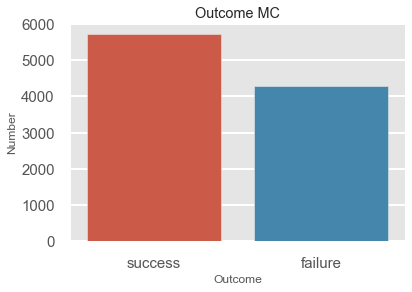

In [80]:
sns.barplot(x=outcome_vc.index, y=outcome_vc.values)
plt.title('Outcome MC')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Outcome')
plt.ylabel('Number')
plt.show()

## B. Reencoding of the number variable, in order to make them more readible

In [81]:
df_encode['agecat'] = pd.cut(df_encode['age_2020'], range(15, 100, 10))
#we are reencoding the age_2020 variable

In [82]:
# CODE TO REENCODE "INHABITANTS" VERSION "AIRE URBAINE"
def reencode_aire_urbaine(nb_inhab):
    if 0 < nb_inhab <= 2000:
        aire_urbaine = 'aire rurale'
    elif 2000 < nb_inhab <= 20000:
        aire_urbaine = 'petite ville'
    elif 20000 < nb_inhab <= 100000:
        aire_urbaine = 'ville_moyenne'
    elif 100000 <  nb_inhab <= 1500000:
        aire_urbaine = 'grande ville'
    elif nb_inhab>1500000:
        aire_urbaine='Paris'
    return aire_urbaine

# j'applique la fonction créee pour le reencoding
df_aire_urbaine = df_encode.copy()
# reencoding
df_aire_urbaine['aire_urbaine'] = df_aire_urbaine['INHABITANTS'].apply(lambda x: reencode_aire_urbaine(x))

## C. Identification of charateristic of people in the success category and in the faillure category

#### 1. Gender

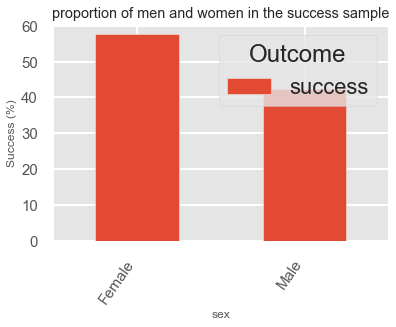

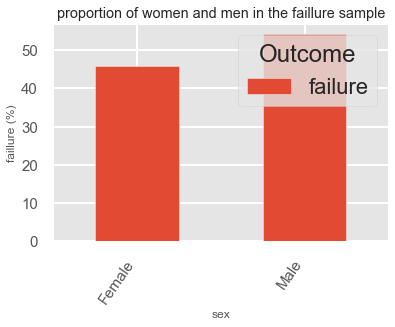

In [83]:
pivot_sex=df_add_info.pivot_table(index='sex', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_sex=pivot_sex[['success']].div(57.20, axis=0)
pivot_prop_sex_f=pivot_sex[['failure']].div(42.80, axis=0)

df_pivot_prop_sex_s = pd.DataFrame(pivot_proportion_success_sex)
df_pivot_prop_sex_f=pd.DataFrame(pivot_prop_sex_f)

#graphical part of the success sample:
df_pivot_prop_sex_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of men and women in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_sex_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of women and men in the faillure sample")
plt.show()

#### 2. IS_STUDENT

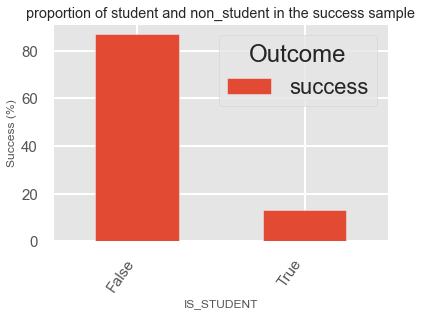

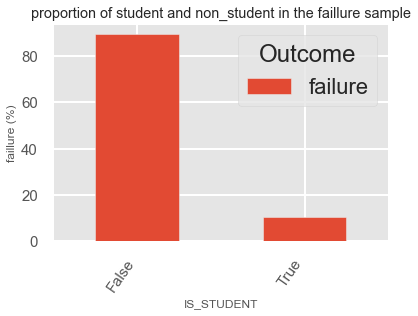

In [84]:
pivot_student=df_add_info.pivot_table(index='IS_STUDENT', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_student=pivot_student[['success']].div(57.20, axis=0)
pivot_prop_student_f=pivot_student[['failure']].div(42.80, axis=0)

df_pivot_prop_student_s = pd.DataFrame(pivot_proportion_success_student)
df_pivot_prop_student_f=pd.DataFrame(pivot_prop_student_f)

#graphical part of the success sample:
df_pivot_prop_student_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of student and non_student in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_student_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of student and non_student in the faillure sample")
plt.show()

In [85]:
#### 3. CSP

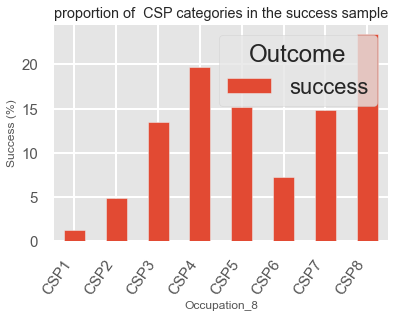

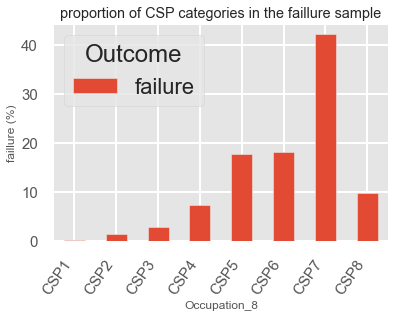

In [86]:
pivot_csp=df_add_info.pivot_table(index='Occupation_8', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_csp=pivot_csp[['success']].div(57.20, axis=0)
pivot_prop_csp_f=pivot_csp[['failure']].div(42.80, axis=0)

df_pivot_prop_csp_s = pd.DataFrame(pivot_proportion_success_csp)
df_pivot_prop_csp_f=pd.DataFrame(pivot_prop_csp_f)

#graphical part of the success sample:
df_pivot_prop_csp_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of  CSP categories in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_csp_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of CSP categories in the faillure sample")
plt.show()

In [87]:
#### 4. Activites

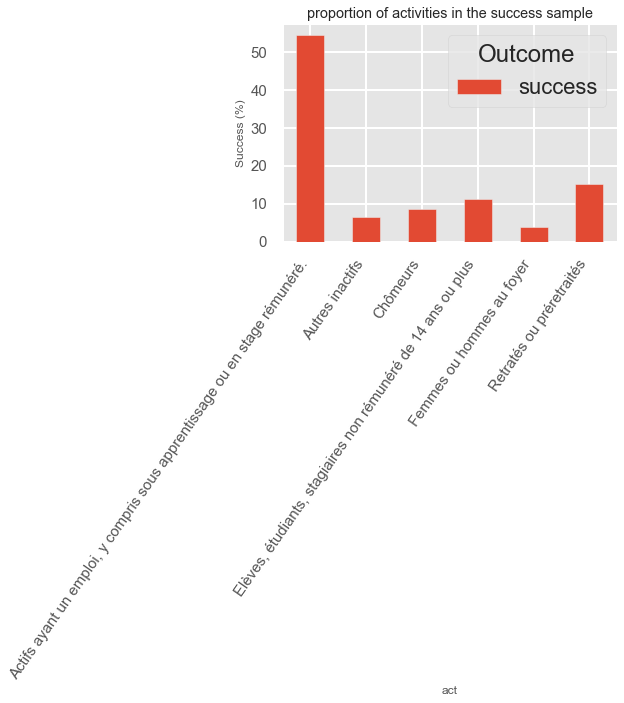

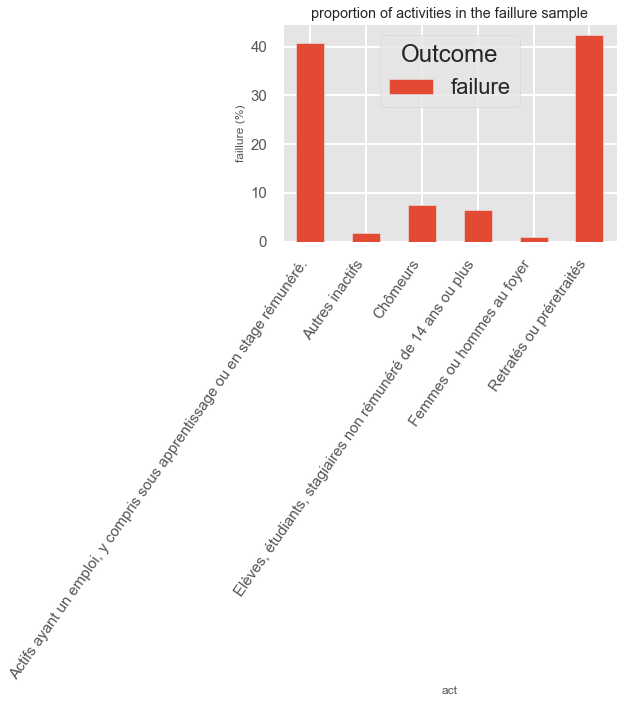

In [88]:
pivot_act=df_encode.pivot_table(index='act', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_act=pivot_act[['success']].div(57.20, axis=0)
pivot_prop_act_f=pivot_act[['failure']].div(42.80, axis=0)

df_pivot_prop_act_s = pd.DataFrame(pivot_proportion_success_act)
df_pivot_prop_act_f=pd.DataFrame(pivot_prop_act_f)

#graphical part of the success sample:
df_pivot_prop_act_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of activities in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_act_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of activities in the faillure sample")
plt.show()

#### 5.Contract

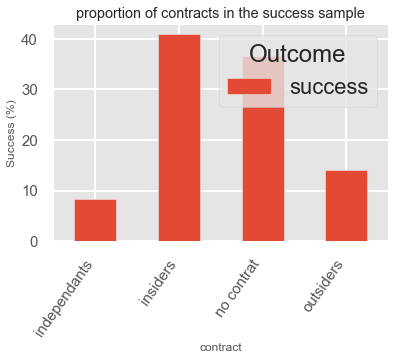

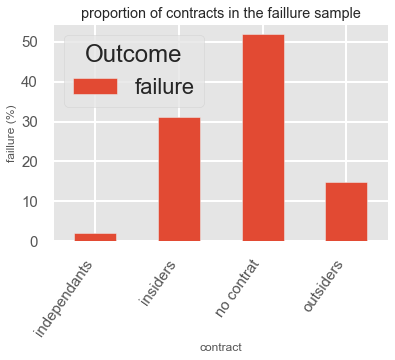

In [89]:
pivot_contract=df_encode.pivot_table(index='contract', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_contract=pivot_contract[['success']].div(57.20, axis=0)
pivot_prop_contract_f=pivot_contract[['failure']].div(42.80, axis=0)

df_pivot_prop_contract_s = pd.DataFrame(pivot_proportion_success_contract)
df_pivot_prop_contract_f=pd.DataFrame(pivot_prop_contract_f)

#graphical part of the success sample:
df_pivot_prop_contract_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of contracts in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_contract_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of contracts in the faillure sample")
plt.show()

#### 6.CLUB

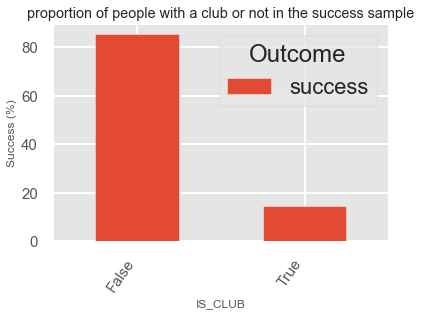

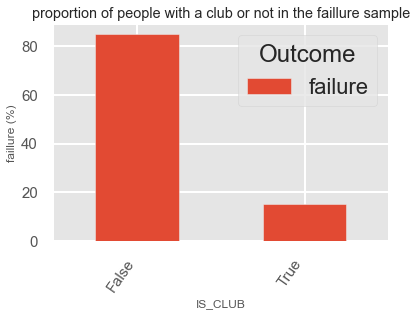

In [90]:
pivot_club=df_encode.pivot_table(index='IS_CLUB', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_club=pivot_club[['success']].div(57.20, axis=0)
pivot_prop_club_f=pivot_club[['failure']].div(42.80, axis=0)

df_pivot_prop_club_s = pd.DataFrame(pivot_proportion_success_club)
df_pivot_prop_club_f=pd.DataFrame(pivot_prop_club_f)

#graphical part of the success sample:
df_pivot_prop_club_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of people with a club or not in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_club_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of people with a club or not in the faillure sample")
plt.show()

#### 7. Degree

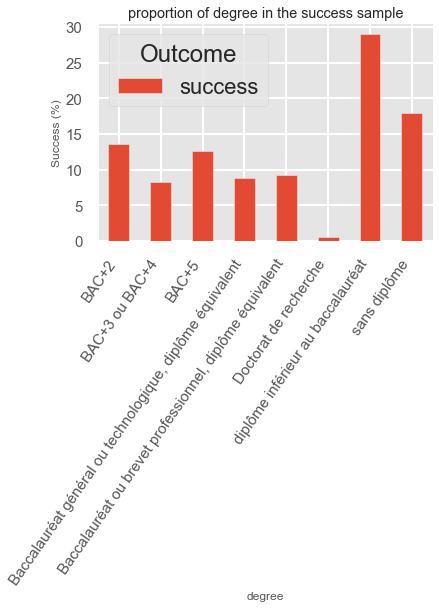

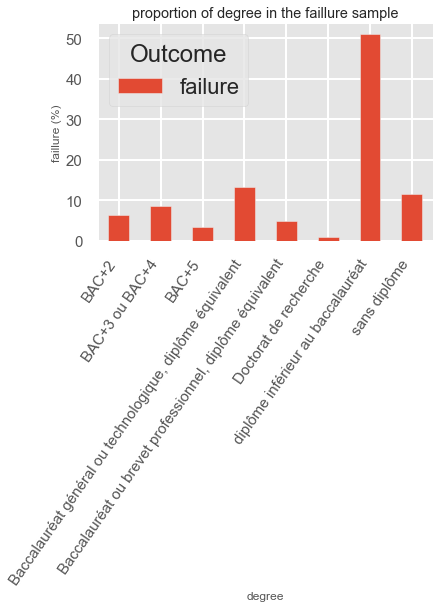

In [91]:
pivot_degree=df_encode.pivot_table(index='degree', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_degree=pivot_degree[['success']].div(57.20, axis=0)
pivot_prop_degree_f=pivot_degree[['failure']].div(42.80, axis=0)

df_pivot_prop_degree_s = pd.DataFrame(pivot_proportion_success_degree)
df_pivot_prop_degree_f=pd.DataFrame(pivot_prop_degree_f)

#graphical part of the success sample:
df_pivot_prop_degree_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of degree in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_degree_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of degree in the faillure sample")
plt.show()

#### 8. Household type

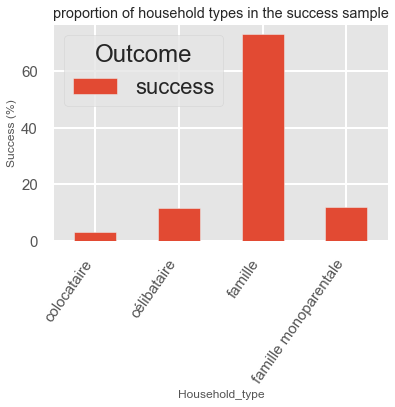

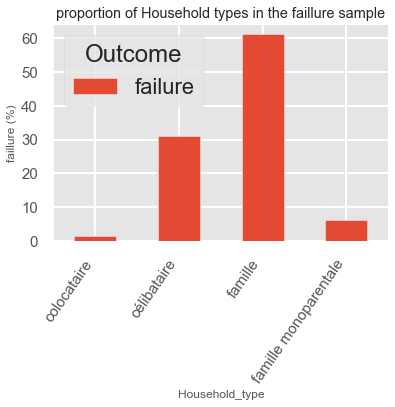

In [92]:
pivot_Household_type=df_encode.pivot_table(index='Household_type', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_Household_type=pivot_Household_type[['success']].div(57.20, axis=0)
pivot_prop_Household_type_f=pivot_Household_type[['failure']].div(42.80, axis=0)

df_pivot_prop_Household_type_s = pd.DataFrame(pivot_proportion_success_Household_type)
df_pivot_prop_Household_type_f=pd.DataFrame(pivot_prop_Household_type_f)

#graphical part of the success sample:
df_pivot_prop_Household_type_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of household types in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_Household_type_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of Household types in the faillure sample")
plt.show()

#### 9. Age

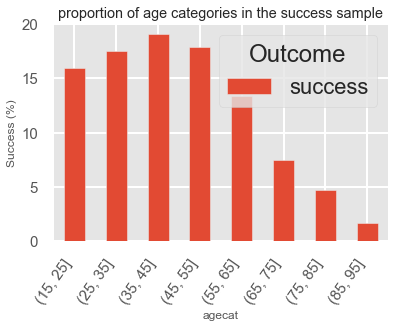

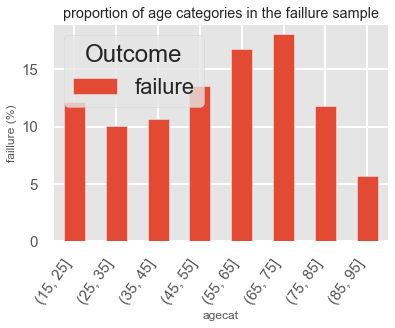

In [93]:
pivot_age=df_encode.pivot_table(index='agecat', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_age=pivot_age[['success']].div(57.20, axis=0)
pivot_prop_age_f=pivot_age[['failure']].div(42.80, axis=0)

df_pivot_prop_age_s = pd.DataFrame(pivot_proportion_success_age)
df_pivot_prop_age_f=pd.DataFrame(pivot_prop_age_f)

#graphical part of the success sample:
df_pivot_prop_age_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of age categories in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_age_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of age categories in the faillure sample")
plt.show()

#### 10. City type

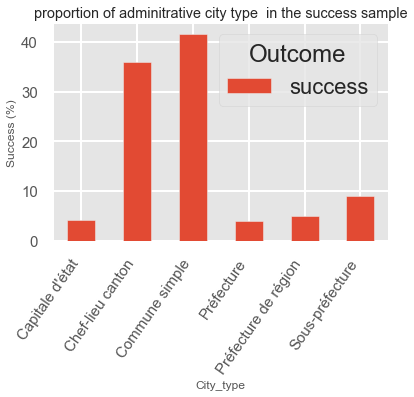

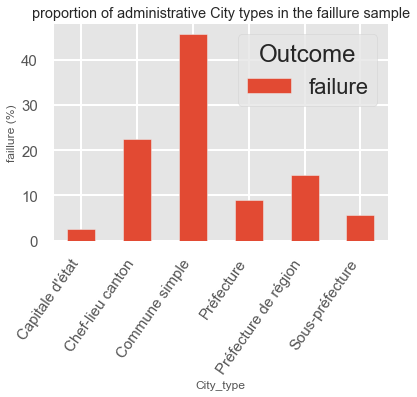

In [94]:
pivot_City_type=df_encode.pivot_table(index='City_type', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_City_type=pivot_City_type[['success']].div(57.20, axis=0)
pivot_prop_City_type_f=pivot_City_type[['failure']].div(42.80, axis=0)

df_pivot_prop_City_type_s = pd.DataFrame(pivot_proportion_success_City_type)
df_pivot_prop_City_type_f=pd.DataFrame(pivot_prop_City_type_f)

#graphical part of the success sample:
df_pivot_prop_City_type_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of adminitrative city type  in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_City_type_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of administrative City types in the faillure sample")
plt.show()

#### 11. Population size of the City

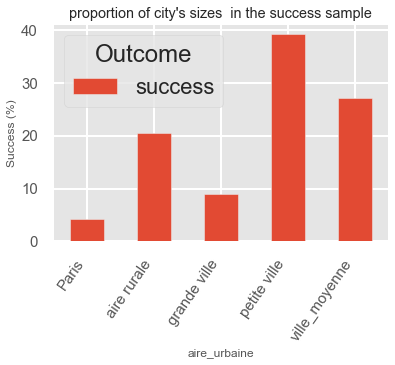

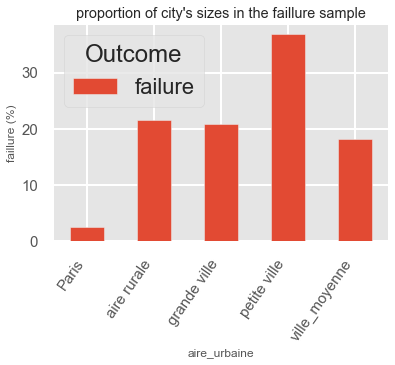

In [95]:
pivot_aire_urbaine=df_aire_urbaine.pivot_table(index='aire_urbaine', columns=['Outcome'], values='f_name', aggfunc='count')

pivot_proportion_success_aire_urbaine=pivot_aire_urbaine[['success']].div(57.20, axis=0)
pivot_prop_aire_urbaine_f=pivot_aire_urbaine[['failure']].div(42.80, axis=0)

df_pivot_prop_aire_urbaine_s = pd.DataFrame(pivot_proportion_success_aire_urbaine)
df_pivot_prop_aire_urbaine_f=pd.DataFrame(pivot_prop_aire_urbaine_f)

#graphical part of the success sample:
df_pivot_prop_aire_urbaine_s.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of city's sizes  in the success sample")
plt.show()
#graphical part of the faillure sample:
df_pivot_prop_aire_urbaine_f.plot(kind='bar')
plt.ylabel('faillure (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.title("proportion of city's sizes in the faillure sample")
plt.show()

## 4. Robustness of the results

# Part 2: Predictive part

## A. Computering of the frequences of the several variable, and comparison to the global success rate

#### 1. Gender

In [96]:
pivot_gender = df_add_info.pivot_table(index=['sex'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_gender = df_add_info.pivot_table(index=['sex'], 
                                values='f_name', aggfunc='count')
deno_array_gender = np.array(denominateur_gender)
pivot_freq_gender = round(pivot_gender / deno_array_gender * 100, 2)
print(pivot_freq_gender)

Outcome  failure  success
sex                      
Female     37.28    62.72
Male       48.91    51.09


#### 2. IS_STUDENT

In [97]:
#we have to compute the frequences of success and failure for both categories
pivot_student = df_add_info.pivot_table(index=['IS_STUDENT'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_student = df_add_info.pivot_table(index=['IS_STUDENT'], 
                                values='f_name', aggfunc='count')
deno_array_student = np.array(denominateur_student)
pivot_freq_student = round(pivot_student / deno_array_student * 100, 2)
print(pivot_freq_student)



Outcome     failure  success
IS_STUDENT                  
False         43.49    56.51
True          37.75    62.25


#### 3. CSP

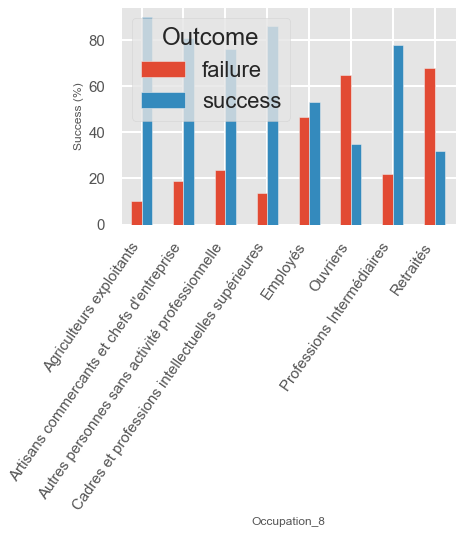

In [98]:
pivot_csp = df_encode.pivot_table(index=['Occupation_8'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_csp = df_encode.pivot_table(index=['Occupation_8'], 
                                values='f_name', aggfunc='count')
deno_array_csp = np.array(denominateur_csp)
pivot_freq_csp = round(pivot_csp / deno_array_csp * 100, 2)

#graphical part:
df_pivot_freq_csp = pd.DataFrame(pivot_freq_csp)
df_pivot_freq_csp.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.show()

#### 4. Activity

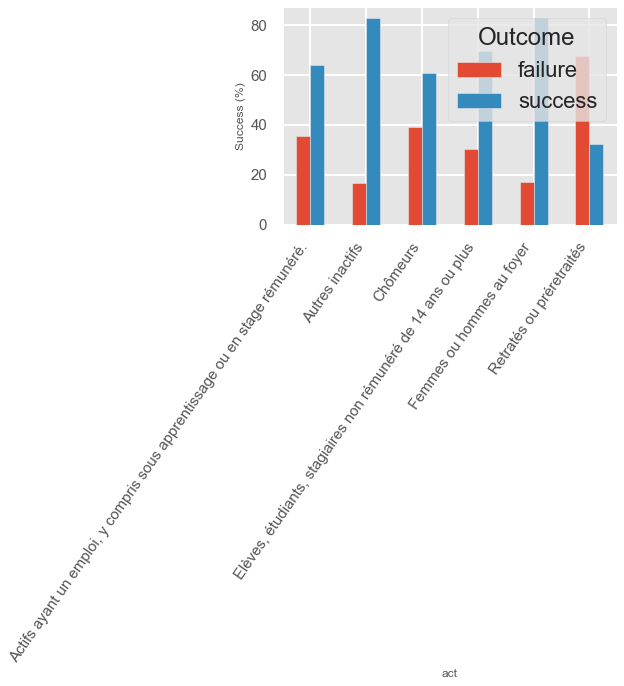

In [99]:
pivot_act = df_encode.pivot_table(index=['act'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_act = df_encode.pivot_table(index=['act'], 
                                values='f_name', aggfunc='count')
deno_array_act = np.array(denominateur_act)
pivot_freq_act = round(pivot_act / deno_array_act * 100, 2)

#graphical part:
df_pivot_freq_act = pd.DataFrame(pivot_freq_act)
df_pivot_freq_act.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.show()

#### 5. Contract

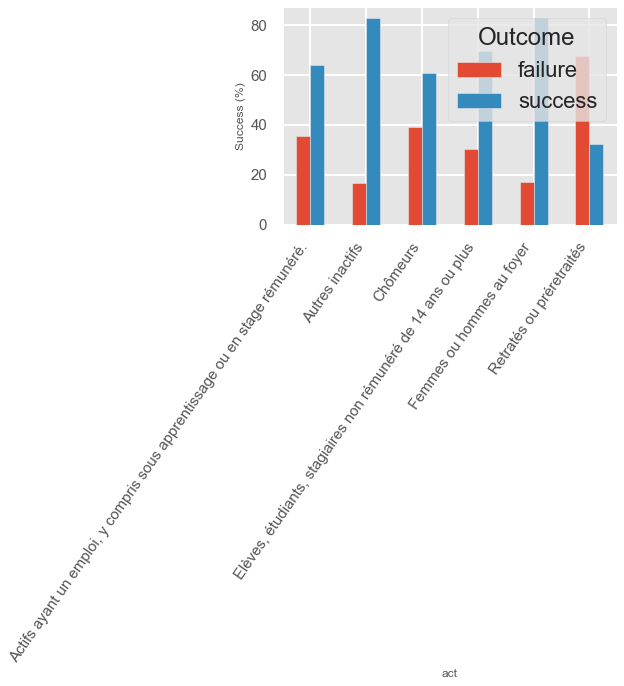

In [100]:
pivot_cont = df_encode.pivot_table(index=['contract'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_cont = df_encode.pivot_table(index=['contract'], 
                                values='f_name', aggfunc='count')
deno_array_cont = np.array(denominateur_act)
pivot_freq_cont = round(pivot_act / deno_array_act * 100, 2)

#graphical part:
df_pivot_freq_cont = pd.DataFrame(pivot_freq_cont)
df_pivot_freq_cont.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.show()

#### 6. CLUBS

Outcome  failure  success
IS_CLUB                  
False      42.63    57.37
True       43.80    56.20


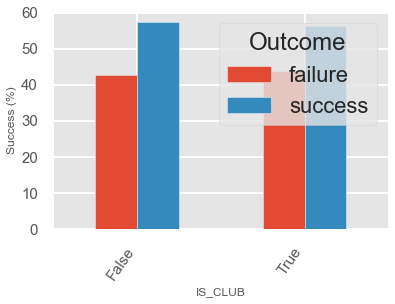

In [101]:
pivot_CLUB = df_encode.pivot_table(index=['IS_CLUB'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_CLUB = df_encode.pivot_table(index=['IS_CLUB'], 
                                values='f_name', aggfunc='count')
deno_array_CLUB = np.array(denominateur_CLUB)
pivot_freq_CLUB = round(pivot_CLUB / deno_array_CLUB * 100, 2)
print(pivot_freq_CLUB)

#graphical part:
df_pivot_freq_CLUB = pd.DataFrame(pivot_freq_CLUB)
df_pivot_freq_CLUB.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.show()

#### 7. Degree

Outcome                                             failure  success
degree                                                              
BAC+2                                                 25.79    74.21
BAC+3 ou BAC+4                                        43.93    56.07
BAC+5                                                 16.36    83.64
Baccalauréat général ou technologique, diplôme ...    53.11    46.89
Baccalauréat ou brevet professionnel, diplôme é...    28.12    71.88
Doctorat de recherche                                 56.92    43.08
diplôme inférieur au baccalauréat                     56.82    43.18
sans diplôme                                          32.61    67.39


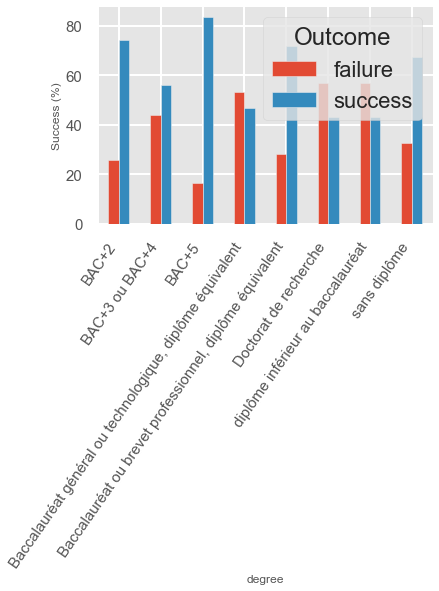

In [102]:
pivot_degree = df_encode.pivot_table(index=['degree'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_degree = df_encode.pivot_table(index=['degree'], 
                                values='f_name', aggfunc='count')
deno_array_degree = np.array(denominateur_degree)
pivot_freq_degree = round(pivot_degree / deno_array_degree * 100, 2)
print(pivot_freq_degree)

#graphical part:
df_pivot_freq_degree = pd.DataFrame(pivot_freq_degree)
df_pivot_freq_degree.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.show()

#### 8. Household_type

Outcome                failure  success
Household_type                         
colocataire              25.93    74.07
célibataire              66.38    33.62
famille                  38.53    61.47
famille monoparentale    27.95    72.05


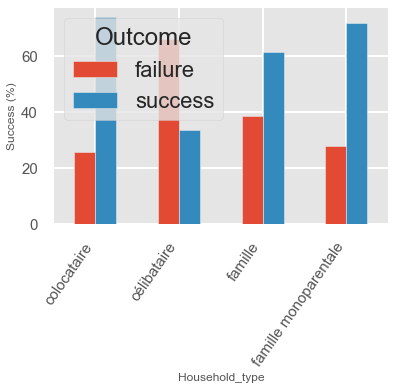

In [103]:
pivot_household = df_encode.pivot_table(index=['Household_type'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_household = df_encode.pivot_table(index=['Household_type'], 
                                values='f_name', aggfunc='count')
deno_array_household = np.array(denominateur_household)
pivot_freq_household = round(pivot_household / deno_array_household * 100, 2)
print(pivot_freq_household)

#graphical part:
df_pivot_freq_household = pd.DataFrame(pivot_freq_household)
df_pivot_freq_household.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.show()

#### 9. Age

Outcome   failure  success
agecat                    
(15, 25]    36.15    63.85
(25, 35]    29.92    70.08
(35, 45]    29.48    70.52
(45, 55]    36.10    63.90
(55, 65]    48.35    51.65
(65, 75]    64.28    35.72
(75, 85]    65.08    34.92
(85, 95]    71.64    28.36


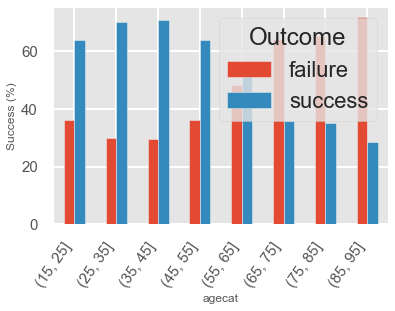

In [104]:
pivot_agecat = df_encode.pivot_table(index=['agecat'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_agecat = df_encode.pivot_table(index=['agecat'], 
                                values='f_name', aggfunc='count')
deno_array_agecat = np.array(denominateur_agecat)
pivot_freq_agecat = round(pivot_agecat / deno_array_agecat * 100, 2)
print(pivot_freq_agecat)

#graphical part:
df_pivot_freq_agecat = pd.DataFrame(pivot_freq_agecat)
df_pivot_freq_agecat.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.show()

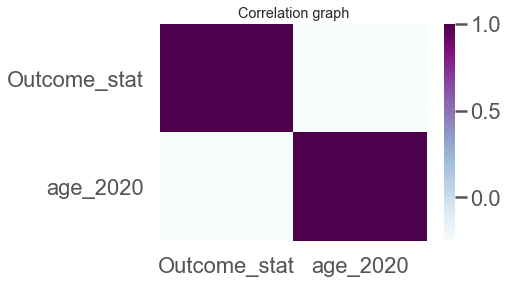

In [105]:
#study of the correlation of the variable "age_cat"
df_corr = df_total[['Outcome_stat', 'age_2020']]
sns.heatmap(df_corr.corr(), cmap="BuPu")
plt.title('Correlation graph')
plt.show()

#### 10. City_type

Outcome               failure  success
City_type                             
Capitale d'état         31.46    68.54
Chef-lieu canton        31.78    68.22
Commune simple          45.10    54.90
Préfecture              62.38    37.62
Préfecture de région    68.36    31.64
Sous-préfecture         32.45    67.55


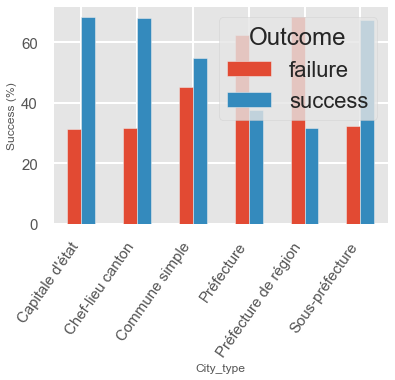

In [106]:
pivot_commune = df_encode.pivot_table(index=['City_type'], columns=['Outcome'], 
                                values='f_name', aggfunc='count')
denominateur_commune = df_encode.pivot_table(index=['City_type'], 
                                values='f_name', aggfunc='count')
deno_array_commune = np.array(denominateur_commune)
pivot_freq_commune = round(pivot_commune / deno_array_commune * 100, 2)
print(pivot_freq_commune)
df_pivot_freq_commune = pd.DataFrame(pivot_freq_commune)
df_pivot_freq_commune.plot(kind='bar')
plt.ylabel('Success (%)')
# design tick labels
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=55, ha="right")
plt.show()

#### 11.The population size, thought the variable Aire_urbaine

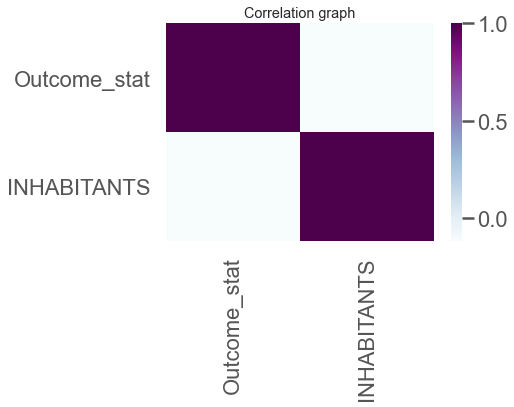

In [107]:
#we first study the correlation between the size of the population, and the success rate
df_corr = df_total[['Outcome_stat','INHABITANTS']]
sns.heatmap(df_corr.corr(), cmap="BuPu")
plt.title('Correlation graph')
plt.show()

In [108]:
pivot_aire_urb = df_aire_urbaine.pivot_table(index=['aire_urbaine'], columns=['Outcome'], 
                                values='INHABITANTS', aggfunc='count')

denominateur_aire_urb = df_aire_urbaine.pivot_table(index=['aire_urbaine'], 
                                values='INHABITANTS', aggfunc='count')
deno_array_aire_urb = np.array(denominateur_aire_urb)
pivot_freq_aire_urb = round(pivot_aire_urb / deno_array_aire_urb * 100, 2)
print(pivot_freq_aire_urb)

Outcome        failure  success
aire_urbaine                   
Paris            31.46    68.54
aire rurale      43.91    56.09
grande ville     63.74    36.26
petite ville     41.26    58.74
ville_moyenne    33.46    66.54


### nota bene: 
we didn't study the variable "Region" and "département" in this part. Indeed, we studeed them in the part 2.3 .

## 2. Robustness of the results: the confidence intervals

#### Gender

In [109]:
l_gender_cat = list(df_add_info['sex'].unique()) # list containing all the
# category names

# loop over each category
for cat in l_gender_cat:
    # get the data of outcome of MC for each category
    if type(cat) == str:
        cat_data = df_add_info[df_add_info['sex'] == cat]['Outcome_stat']
    # for missing values
    else:
        cat_data = df_add_info[df_add_info['sex'].isna()]['Outcome_stat']
    # check if the len of cat_data is > 30 ou < 30 to decide if we use 
    # Normal or t distribution for 95% CI
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
        # st.sem(cat_data) = sigma / np.sqrt(N)
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of Male is:(0.4966304003993067, 0.5250858129677605)
The 95% CI of Female is:(0.6140909416502734, 0.640236621598728)


#### student

In [110]:
l_cat_student = list(df_encode['IS_STUDENT'].unique()) # list containing all the
# category names

# loop over each category
for cat in l_cat_student:
    # get the data of outcome of MC for each category
    if type(cat) == np.bool_:
        cat_data = df_encode[df_encode['IS_STUDENT'] == cat]['Outcome_stat']
    # for missing values
    else:
        cat_data = df_encode[df_encode['IS_STUDENT'].isna()]['Outcome_stat']
    # check if the len of cat_data is > 30 ou < 30 to decide if we use 
    # Normal or t distribution for 95% CI
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
        # st.sem(ind_data) = sigma / np.sqrt(N)
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of False is:(0.5547553665176432, 0.5754719062096294)
The 95% CI of True is:(0.5950611026273146, 0.6499388973726855)


#### CSP

In [111]:
l_csp_cat = list(df_encode['Occupation_8'].unique())

for cat in l_csp_cat:
    if type(cat) == str:
        cat_data = df_encode[df_encode['Occupation_8'] == cat]['Outcome_stat']
    else:
        cat_data = df_encode[df_encode['Occupation_8'].isna()]['Outcome_stat']
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of Agriculteurs exploitants is:(0.8317845957697059, 0.9656837586606739)
The 95% CI of Professions Intermédiaires is:(0.7596663647219889, 0.8023571973015732)
The 95% CI of Artisans commercants et chefs d'entreprise is:(0.7702718094350052, 0.8529165963620964)
The 95% CI of Ouvriers is:(0.3221888454506361, 0.3762238529620623)
The 95% CI of Retraités is:(0.30105814045164897, 0.3365030187504587)
The 95% CI of Autres personnes sans activité professionnelle is:(0.741589140177314, 0.7814091562451733)
The 95% CI of Cadres et professions intellectuelles supérieures is:(0.8386280857869062, 0.8839669925128701)
The 95% CI of Employés is:(0.5089797461647766, 0.5575227168894107)


#### activity

In [112]:
l_act_cat = list(df_encode['act'].unique())

for cat in l_act_cat:
    if type(cat) == str:
        cat_data = df_encode[df_encode['act'] == cat]['Outcome_stat']
    else:
        cat_data = df_encode[df_encode['act'].isna()]['Outcome_stat']
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of Actifs ayant un emploi, y compris sous apprentissage ou en stage rémunéré. is:(0.628930985880713, 0.6558453785017245)
The 95% CI of Chômeurs is:(0.5737574187080565, 0.6410573961067583)
The 95% CI of Retratés ou préretraités is:(0.30685843870659046, 0.34223179523325353)
The 95% CI of Elèves, étudiants, stagiaires non rémunéré de 14 ans ou plus is:(0.6651895299162315, 0.7247886835913938)
The 95% CI of Autres inactifs is:(0.7961905907700005, 0.8659715713921615)
The 95% CI of Femmes ou hommes au foyer is:(0.7816712646735469, 0.8735011491195566)


#### contract

In [113]:
l_contr_cat = list(df_encode['contract'].unique()) # list containing all the
# category names

# loop over each category
for cat in l_contr_cat:
    # get the data of outcome of MC for each category
    if type(cat) == str:
        cat_data = df_encode[df_encode['contract'] == cat]['Outcome_stat']
    # for missing values
    else:
        cat_data = df_encode[df_encode['contract'].isna()]['Outcome_stat']
    # check if the len of cat_data is > 30 ou < 30 to decide if we use 
    # Normal or t distribution for 95% CI
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
        # st.sem(cat_data) = sigma / np.sqrt(N)
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of independants is:(0.8039183208870915, 0.8650957636199508)
The 95% CI of insiders is:(0.621946378429066, 0.6530604354166685)
The 95% CI of outsiders is:(0.5341925438830586, 0.58536516171473)
The 95% CI of no contrat is:(0.4709539172606058, 0.5007791689303116)


#### degree

In [114]:
l_contr_degree = list(df_encode['degree'].unique()) # list containing all the
# category names

# loop over each category
for cat in l_contr_degree:
    # get the data of outcome of MC for each category
    if type(cat) == str:
        cat_data = df_encode[df_encode['degree'] == cat]['Outcome_stat']
    # for missing values
    else:
        cat_data = df_encode[df_encode['degree'].isna()]['Outcome_stat']
    # check if the len of cat_data is > 30 ou < 30 to decide if we use 
    # Normal or t distribution for 95% CI
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
        # st.sem(cat_data) = sigma / np.sqrt(N)
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of diplôme inférieur au baccalauréat is:(0.41615017188641673, 0.44745076342145546)
The 95% CI of BAC+2 is:(0.715609230978869, 0.768631456700214)
The 95% CI of BAC+5 is:(0.8117201176519483, 0.8611337106543163)
The 95% CI of Baccalauréat général ou technologique, diplôme équivalent is:(0.4390776662832892, 0.49871249156257896)
The 95% CI of Baccalauréat ou brevet professionnel, diplôme équivalent is:(0.6862457899467008, 0.7512542100532992)
The 95% CI of sans diplôme is:(0.6503407128823305, 0.6974283159890605)
The 95% CI of BAC+3 ou BAC+4 is:(0.5271319065162466, 0.5942966649123248)
The 95% CI of Doctorat de recherche is:(0.30945140312572766, 0.552087058412734)


#### Household_type

In [115]:
l_contr_h = list(df_encode['Household_type'].unique()) # list containing all the
# category names

# loop over each category
for cat in l_contr_h:
    # get the data of outcome of MC for each category
    if type(cat) == str:
        cat_data = df_encode[df_encode['Household_type'] == cat]['Outcome_stat']
    # for missing values
    else:
        cat_data = df_encode[df_encode['Household_type'].isna()]['Outcome_stat']
    # check if the len of cat_data is > 30 ou < 30 to decide if we use 
    # Normal or t distribution for 95% CI
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
        # st.sem(cat_data) = sigma / np.sqrt(N)
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of famille is:(0.6031512209999378, 0.626303860001535)
The 95% CI of célibataire is:(0.3154883681141594, 0.3568223888579521)
The 95% CI of famille monoparentale is:(0.6921268723135379, 0.7489575906687354)
The 95% CI of colocataire is:(0.6855278276326223, 0.7959536538488591)


#### age

In [116]:
l_contr_agecat = list(df_encode['agecat'].unique()) # list containing all the
# category names

# loop over each category
for cat in l_contr_agecat:
    # get the data of outcome of MC for each category
    try:
        if math.isnan(cat):
            cat_data = df_encode[df_encode['agecat'].isna()]['Outcome_stat']
    except TypeError:
        cat_data = df_encode[df_encode['agecat'] == cat]['Outcome_stat']

    # check if the len of cat_data is > 30 ou < 30 to decide if we use 
    # Normal or t distribution for 95% CI
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
        # st.sem(cat_data) = sigma / np.sqrt(N)
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of (45.0, 55.0] is:(0.6154414909486786, 0.6625097895010402)
The 95% CI of (55.0, 65.0] is:(0.49108340379665477, 0.5420023490730278)
The 95% CI of (35.0, 45.0] is:(0.6825086413417661, 0.7279632397183503)
The 95% CI of (15.0, 25.0] is:(0.6136374097711927, 0.6634037625944738)
The 95% CI of (25.0, 35.0] is:(0.6771292238859844, 0.7245444162813796)
The 95% CI of (85.0, 95.0] is:(0.23578324870359182, 0.3314682132847123)
The 95% CI of (65.0, 75.0] is:(0.33009094311099346, 0.3843137196700223)
The 95% CI of (75.0, 85.0] is:(0.31566341152488664, 0.382790196722536)
The 95% CI of nan is:(0.6023431487685582, 0.7381973917719824)


#### City_type

In [117]:
l_contr_commune = list(df_encode['City_type'].unique()) # list containing all the
# category names

# loop over each category
for cat in l_contr_commune:
    # get the data of outcome of MC for each category
    if type(cat) == str:
        cat_data = df_encode[df_encode['City_type'] == cat]['Outcome_stat']
    # for missing values
    else:
        cat_data = df_encode[df_encode['City_type'].isna()]['Outcome_stat']
    # check if the len of cat_data is > 30 ou < 30 to decide if we use 
    # Normal or t distribution for 95% CI
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
        # st.sem(cat_data) = sigma / np.sqrt(N)
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of Commune simple is:(0.5342344081714288, 0.5638318901711128)
The 95% CI of Chef-lieu canton is:(0.6656108885316402, 0.6988071008863491)
The 95% CI of Sous-préfecture is:(0.6420784469707181, 0.7089149305127256)
The 95% CI of Préfecture de région is:(0.28614376572219113, 0.3467118020837625)
The 95% CI of Préfecture is:(0.3378724263248847, 0.41457057041778633)
The 95% CI of Capitale d'état is:(0.6370887306274804, 0.7336977862264522)


In [118]:
#### Size of the population of the city

In [119]:
l_contr_taille_commune = list(df_aire_urbaine['aire_urbaine'].unique()) # list containing all the
# category names

# loop over each category
for cat in l_contr_taille_commune:
    # get the data of outcome of MC for each category
    if type(cat) == str:
        cat_data = df_aire_urbaine[df_aire_urbaine['aire_urbaine'] == cat]['Outcome_stat']
    # for missing values
    else:
        cat_data = df_aire_urbaine[df_aire_urbaine['aire_urbaine'].isna()]['Outcome_stat']
    # check if the len of cat_data is > 30 ou < 30 to decide if we use 
    # Normal or t distribution for 95% CI
    if len(cat_data) < 30:
        conf_int = st.t.interval(alpha=0.95, df=len(cat_data)-1, loc=np.mean(cat_data), 
                      scale=st.sem(cat_data))
    else:
        conf_int = st.norm.interval(alpha=0.95, loc=np.mean(cat_data), 
                         scale=st.sem(cat_data))
        # st.sem(cat_data) = sigma / np.sqrt(N)
    print('The 95% CI of ' + str(cat) + ' is:' + str((conf_int)))

The 95% CI of aire rurale is:(0.5396028444364274, 0.5821155326518781)
The 95% CI of petite ville is:(0.5717523249950139, 0.6029922387985412)
The 95% CI of ville_moyenne is:(0.6462203027572574, 0.6845390280020734)
The 95% CI of grande ville is:(0.33741537276238576, 0.3877809156030675)
The 95% CI of Paris is:(0.6370887306274804, 0.7336977862264522)


## Data Prepartion

In [120]:
# variable selected for prediction of MC outcome
# - sex
# - age_2020
# - degree
# - act
# - Occupation_8
# - contract
# - City_type
# - INHABITANTS
# - aire_urbaine
# is_south

In [121]:
# adding is_south variable
l_south_reg = ['Nouvelle-Aquitaine', 'Occitanie',"Provence-Alpes-Côte d'Azur", "Auvergne-Rhône-Alpes", "Corse"]
df['is_south'] = np.where(df['Nom de la région'].isin(l_south_reg), 1, 0)

In [122]:
df_model = df[['Outcome_stat', 'sex', 'age_2020', 'degree', 'act', 'Occupation_8', 'contract', 'City_type', 'INHABITANTS',
               'aire_urbaine', 'is_south']].copy()

In [123]:
df_model.head()

Outcome_stat   sex  age_2020                             degree  \
Key                                                                    
0               1  Male        51  diplôme inférieur au baccalauréat   
1               0  Male        52  diplôme inférieur au baccalauréat   
2               1  Male        52  diplôme inférieur au baccalauréat   
3               1  Male        56  diplôme inférieur au baccalauréat   
4               1  Male        42                              BAC+2   

                                                   act  \
Key                                                      
0    Actifs ayant un emploi, y compris sous apprent...   
1    Actifs ayant un emploi, y compris sous apprent...   
2    Actifs ayant un emploi, y compris sous apprent...   
3    Actifs ayant un emploi, y compris sous apprent...   
4    Actifs ayant un emploi, y compris sous apprent...   

                   Occupation_8      contract         City_type  INHABITANTS  \
Key                                                                            
0      Agriculteurs exploitants  independants    Commune simple          540   
1    Professions Intermédiaires      insiders    Commune simple          540   
2      Agriculteurs exploitants  independants  Chef-lieu canton         7453   
3      Agriculteurs exploitants  independants    Commune simple         2480   
4      Agriculteurs exploitants  independants    Commune simple          913   

     aire_urbaine  is_south  
Key                          
0     aire rurale         1  
1     aire rurale         1  
2    petite ville         1  
3    petite ville         0  
4     aire rurale         1

In [124]:
df_clf = pd.get_dummies(df_model)

In [125]:
df_clf.columns

Index(['Outcome_stat', 'age_2020', 'INHABITANTS', 'is_south', 'sex_Female',
       'sex_Male', 'degree_BAC+2', 'degree_BAC+3 ou BAC+4', 'degree_BAC+5',
       'degree_Baccalauréat général ou technologique, diplôme équivalent',
       'degree_Baccalauréat ou brevet professionnel, diplôme équivalent',
       'degree_Doctorat de recherche',
       'degree_diplôme inférieur au baccalauréat', 'degree_sans diplôme',
       'act_Actifs ayant un emploi, y compris sous apprentissage ou en stage rémunéré.',
       'act_Autres inactifs', 'act_Chômeurs',
       'act_Elèves, étudiants, stagiaires non rémunéré de 14 ans ou plus',
       'act_Femmes ou hommes au foyer', 'act_Retratés ou préretraités',
       'Occupation_8_Agriculteurs exploitants',
       'Occupation_8_Artisans commercants et chefs d'entreprise',
       'Occupation_8_Autres personnes sans activité professionnelle',
       'Occupation_8_Cadres et professions intellectuelles supérieures',
       'Occupation_8_Employés', 'Occupation_8_O

In [126]:
# drop useless dummies
df_clf.drop('sex_Male', inplace=True, axis=1)

In [127]:
len(df_clf.columns) # 42 columns

42

## Model Building

### <u>Benchmark Model 1 (using a minimal set of variables)</u>

In [128]:
# Results of the algorithm are very poor let's try with minimal variables

In [129]:
y = df_clf['Outcome_stat']
X = df_clf[['age_2020', 'sex_Female', 'is_south']]
X['contract'] = df['contract'].copy()
X = pd.get_dummies(X, columns=['contract'])
X.head()

<ipython-input-129-494f41b7c3dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contract'] = df['contract'].copy()


age_2020  sex_Female  is_south  contract_independants  contract_insiders  \
Key                                                                             
0          51           0         1                      1                  0   
1          52           0         1                      0                  1   
2          52           0         1                      1                  0   
3          56           0         0                      1                  0   
4          42           0         1                      1                  0   

     contract_no contrat  contract_outsiders  
Key                                           
0                      0                   0  
1                      0                   0  
2                      0                   0  
3                      0                   0  
4                      0                   0

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [131]:
model = LogisticRegression(solver='liblinear', random_state=42)

In [132]:
model.fit(X_train, y_train)
ytrain_proba = model.predict_proba(X_train)
ytrain_pred = model.predict(X_train)
accuracy_score(ytrain_pred, y_train)

0.7127142857142857

In [133]:
# evaluate accuracy using test set
yhat = model.predict(X_test)
print(accuracy_score(y_test, yhat))

0.7076666666666667


In [134]:
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.03125
Feature: 1, Score: 0.81442
Feature: 2, Score: -1.75172
Feature: 3, Score: 1.91622
Feature: 4, Score: 0.32611
Feature: 5, Score: 0.03262
Feature: 6, Score: -0.32594


In [135]:
### <u>Benchmark Model 2 (using all the variables identified as useful in the descriptive analysis)</u>

In [136]:
y = df_clf['Outcome_stat']
X = df_clf.drop('Outcome_stat', axis=1)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, 
                                                    test_size=0.30, random_state=42)

In [138]:
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [139]:
ytrain_proba = model.predict_proba(X_train)
ytrain_pred = model.predict(X_train)

In [140]:
accuracy_score(ytrain_pred, y_train)

0.5744285714285714

In [141]:
# evaluate accuracy using test set
yhat = model.predict(X_test)
print(accuracy_score(y_test, yhat))

0.5663333333333334


In [142]:
# Results are really bad using all the variables, let's proceed do some feature selection

## Model - Using Decision Tree Classifier

In [143]:
y = df_clf['Outcome_stat']
X = df_clf.drop('Outcome_stat', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, 
                                                    test_size=0.30, random_state=42)

In [144]:
DecisionTree_Class_Model = DecisionTreeClassifier(random_state=42)
DecisionTree_Class_Model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [145]:
ytrain_pred = DecisionTree_Class_Model.predict(X_train)

In [146]:
ytrain_pred

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [147]:
accuracy_score(y_train, ytrain_pred) # there's clearly overfitting

0.9988571428571429

In [148]:
# using test set:
y_pred = DecisionTree_Class_Model.predict(X_test)
accuracy_score(y_test, y_pred)
# a bit of overfitting, let's then look at feature importance.

0.7516666666666667

In [149]:
l_var_dt = list(X.columns)
l_var_keep = []

Feature: 0, age_2020, Score: 0.15548
Feature: 1, INHABITANTS, Score: 0.22461
Feature: 2, is_south, Score: 0.12942
Feature: 3, sex_Female, Score: 0.04054
Feature: 4, degree_BAC+2, Score: 0.01610
Feature: 5, degree_BAC+3 ou BAC+4, Score: 0.01587
Feature: 6, degree_BAC+5, Score: 0.01176
Feature: 7, degree_Baccalauréat général ou technologique, diplôme équivalent, Score: 0.01500
Feature: 8, degree_Baccalauréat ou brevet professionnel, diplôme équivalent, Score: 0.01797
Feature: 9, degree_Doctorat de recherche, Score: 0.00303
Feature: 10, degree_diplôme inférieur au baccalauréat, Score: 0.02855
Feature: 11, degree_sans diplôme, Score: 0.01970
Feature: 12, act_Actifs ayant un emploi, y compris sous apprentissage ou en stage rémunéré., Score: 0.00500
Feature: 13, act_Autres inactifs, Score: 0.00448
Feature: 14, act_Chômeurs, Score: 0.00576
Feature: 15, act_Elèves, étudiants, stagiaires non rémunéré de 14 ans ou plus, Score: 0.00381
Feature: 16, act_Femmes ou hommes au foyer, Score: 0.00041
Fe

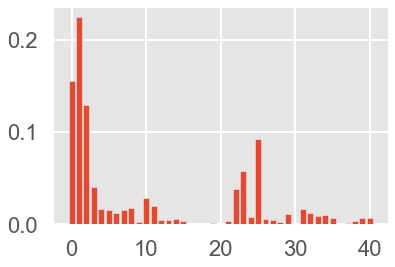

In [150]:
# using CART (classficiation and regression tree) algortihm to assess Feature Importance 
# ressource used: https://machinelearningmastery.com/calculate-feature-importance-with-python/
importance = DecisionTree_Class_Model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, {}, Score: %.5f'.format(l_var_dt[i]) % (i,v))
    if v > 0.01: # threshold to select variables
        l_var_keep.append(l_var_dt[i])
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [151]:
l_var_keep

['age_2020',
 'INHABITANTS',
 'is_south',
 'sex_Female',
 'degree_BAC+2',
 'degree_BAC+3 ou BAC+4',
 'degree_BAC+5',
 'degree_Baccalauréat général ou technologique, diplôme équivalent',
 'degree_Baccalauréat ou brevet professionnel, diplôme équivalent',
 'degree_diplôme inférieur au baccalauréat',
 'degree_sans diplôme',
 'Occupation_8_Employés',
 'Occupation_8_Ouvriers',
 'Occupation_8_Retraités',
 'contract_outsiders',
 'City_type_Chef-lieu canton',
 'City_type_Commune simple',
 'City_type_Préfecture de région']

## Last Model improved with Feature selection

In [152]:
###### from this variable selection it seems that the most relevant variables in our prediction are:
# - age_2020
# - INHABITANTS
# - sex 
# - is_south
# - Occupation_8
# - degree 
# - City type
# let's build a new decision tree algortihm only using those variables

In [153]:
y = df_clf['Outcome_stat']
X = df[['age_2020', 'INHABITANTS', 'is_south', 'Occupation_8', 'degree', 'City_type']]
X['sex'] = df_clf.loc[:, 'sex_Female'].copy()
X = pd.get_dummies(X, columns=['Occupation_8', 'degree', 'City_type'])
X

<ipython-input-153-861052ac8a48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sex'] = df_clf.loc[:, 'sex_Female'].copy()


age_2020  INHABITANTS  is_south  sex  \
Key                                          
0           51          540         1    0   
1           52          540         1    0   
2           52         7453         1    0   
3           56         2480         0    0   
4           42          913         1    0   
...        ...          ...       ...  ...   
9995        79         4350         1    1   
9996        63          311         1    1   
9997        80          402         0    1   
9998        69         3457         0    1   
9999        60         2231         0    1   

      Occupation_8_Agriculteurs exploitants  \
Key                                           
0                                         1   
1                                         0   
2                                         1   
3                                         1   
4                                         1   
...                                     ...   
9995                                      0   
9996                                      0   
9997                                      0   
9998                                      0   
9999                                      0   

      Occupation_8_Artisans commercants et chefs d'entreprise  \
Key                                                             
0                                                     0         
1                                                     0         
2                                                     0         
3                                                     0         
4                                                     0         
...                                                 ...         
9995                                                  0         
9996                                                  0         
9997                                                  0         
9998                                                  0         
9999                                                  0         

      Occupation_8_Autres personnes sans activité professionnelle  \
Key                                                                 
0                                                     0             
1                                                     0             
2                                                     0             
3                                                     0             
4                                                     0             
...                                                 ...             
9995                                                  1             
9996                                                  1             
9997                                                  1             
9998                                                  1             
9999                                                  1             

      Occupation_8_Cadres et professions intellectuelles supérieures  \
Key                                                                    
0                                                     0                
1                                                     0                
2                                                     0                
3                                                     0                
4                                                     0                
...                                                 ...                
9995                                                  0                
9996                                                  0                
9997                                                  0                
9998                                                  0                
9999                                                  0                

      Occupation_8_Employés  Occupation_8_Ouvriers  \
Key                                                  
0     

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, 
                                                    test_size=0.30, random_state=42)

In [155]:
DecisionTree_Class_Model = DecisionTreeClassifier(random_state=42)
DecisionTree_Class_Model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [156]:
ytrain_pred = DecisionTree_Class_Model.predict(X_train)

In [157]:
accuracy_score(y_train, ytrain_pred) # still signs of overfitting 

0.9984285714285714

In [158]:
# using test set:
y_pred = DecisionTree_Class_Model.predict(X_test)
accuracy_score(y_test, y_pred)
# overfitting remains fairly strong.However results on the the test set are fairly good, despite reducing the use of many variables.

0.753

the code used to perform this post pruning is directly borrowed from the following github notebook:
https://github.com/krishnaik06/Post_Pruning_DecisionTre/blob/master/plot_cost_complexity_pruning.ipynb

In [159]:
path = DecisionTree_Class_Model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [160]:
ccp_alphas

array([0.00000000e+00, 0.00000000e+00, 3.57142857e-05, 4.28571429e-05,
       4.43349754e-05, 4.76190476e-05, 4.76190476e-05, 4.76190476e-05,
       4.76190476e-05, 5.46218487e-05, 5.95238095e-05, 6.63265306e-05,
       6.66666667e-05, 6.94980695e-05, 6.95488722e-05, 6.96864111e-05,
       7.01680672e-05, 7.03781513e-05, 7.10034014e-05, 7.14285714e-05,
       7.61904762e-05, 7.61904762e-05, 7.61904762e-05, 7.93650794e-05,
       8.16326531e-05, 8.18101154e-05, 8.36571429e-05, 8.46560847e-05,
       8.46560847e-05, 8.57142857e-05, 8.57142857e-05, 8.57142857e-05,
       8.57142857e-05, 8.57142857e-05, 8.57142857e-05, 8.73015873e-05,
       8.88888889e-05, 8.92857143e-05, 9.02255639e-05, 9.04761905e-05,
       9.07029478e-05, 9.07029478e-05, 9.10973085e-05, 9.20634921e-05,
       9.25170068e-05, 9.31677019e-05, 9.32203390e-05, 9.34411500e-05,
       9.35064935e-05, 9.38578330e-05, 9.39153439e-05, 9.40906483e-05,
       9.41915228e-05, 9.45326279e-05, 9.52380952e-05, 9.52380952e-05,
      

In [161]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.06312830557153609


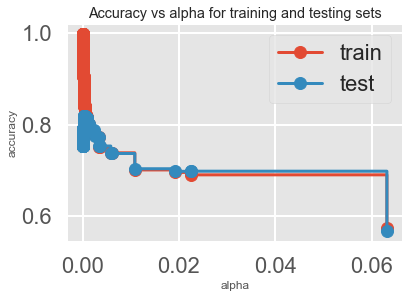

In [162]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [163]:
# to avoid overfitting we want to choose alpha (a level of complexity) for which the accuracy on train set and test set is
# the best, while limiting the performance gap between those sets (we want to generalize well).
# Here it seems that a very small alpha of 0.003 could do the job (having an alpha between 0 and 0.01)

In [164]:
clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.003)
clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.003, random_state=42)

In [165]:
ytrain_pred = clf.predict(X_train)
accuracy_score(y_train, ytrain_pred) # the overfitting is well reduced

0.7768571428571428

In [166]:
pred=clf.predict(X_test)
accuracy_score(y_test, pred) # the algorithm seems to generalize well and the overall performance on the test set is improved!

0.7753333333333333

# Part 3: Grouped analysis

## Import Data

In [167]:
# modify categories of variables
for col_name in df_total.columns:
    # spot categorical variables but careful we don't want to change the category of boolean variables
    if (len(df_total[col_name].unique()) <= 100) and (len(df_total[col_name].unique()) > 2):
        df_total[col_name] = df_total[col_name].astype('category')

# manual rectifications
df_total['Outcome_stat'] = df_total['Outcome_stat'].astype('bool')
df_total['sex'] = df_total['sex'].astype('category')
df_total['Outcome'] = df_total['Outcome'].astype('category')
df_total['age_2020'] = df_total['age_2020'].astype('int')

In [168]:
df_total.head(3)

f_name LAST NAME  IS_STUDENT   sex  age_2020 degree   act  \
0  JEAN-FRANÇOIS     GUYON       False  Male        51  HD1_3  AT11   
1        THIERRY  GIUSEPPI       False  Male        52  HD1_3  AT11   
2         DIDIER   BRUSCHI       False  Male        52  HD1_3  AT11   

  OCCUPATION_24 Insee_code Household_type Occupation_8  Outcome    contract  \
0       SPC-1-0      03184      typemr4.1         CSP1  success  contrat2|1   
1       SPC-4-8      03184      typemr1.1         CSP4  failure  contrat1|6   
2       SPC-1-0      07042      typemr4.4         CSP1  success  contrat2|1   

   Outcome_stat   Nom de la commune         City_type dep              X  \
0          True            Montilly    Commune simple  03  718372.600841   
1         False            Montilly    Commune simple  03  718372.600841   
2          True  Bourg-Saint-Andéol  Chef-lieu canton  07  828572.584085   

              Y        Lat      long  INHABITANTS Nom du département reg  \
0  6.612303e+06  46.610529  3.240057          540             Allier  84   
1  6.612303e+06  46.610529  3.240057          540             Allier  84   
2  6.366208e+06  44.383087  4.613984         7453            Ardèche  84   

       Nom de la région  IS_CLUB  
0  Auvergne-Rhône-Alpes    False  
1  Auvergne-Rhône-Alpes    False  
2  Auvergne-Rhône-Alpes     True

In [169]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   f_name              10000 non-null  object  
 1   LAST NAME           10000 non-null  object  
 2   IS_STUDENT          10000 non-null  bool    
 3   sex                 10000 non-null  category
 4   age_2020            10000 non-null  int32   
 5   degree              10000 non-null  category
 6   act                 10000 non-null  category
 7   OCCUPATION_24       10000 non-null  category
 8   Insee_code          10000 non-null  object  
 9   Household_type      10000 non-null  category
 10  Occupation_8        10000 non-null  category
 11  Outcome             10000 non-null  category
 12  contract            10000 non-null  category
 13  Outcome_stat        10000 non-null  bool    
 14  Nom de la commune   10000 non-null  object  
 15  City_type           10000 non-null  c

## Departemental Analysis

In [170]:
# Find the departement where the success rate was the highest
df_total.groupby('Nom du département')['Outcome_stat'].mean().sort_values(ascending=False)

Nom du département
Hauts-de-Seine             0.917749
Val-d'Oise                 0.913793
Essonne                    0.911917
Val-de-Marne               0.898990
Ardennes                   0.888889
Aisne                      0.875000
Yvelines                   0.868421
Seine-et-Marne             0.864078
Seine-Saint-Denis          0.863813
Nièvre                     0.857143
Yonne                      0.836735
Vendée                     0.816327
Haute-Saône                0.805556
Doubs                      0.783784
Meurthe-et-Moselle         0.782353
Meuse                      0.777778
Saône-et-Loire             0.777778
Jura                       0.750000
Côte-d'Or                  0.746032
Maine-et-Loire             0.743169
Oise                       0.737143
Eure                       0.725806
Orne                       0.724138
Seine-Maritime             0.723906
Ain                        0.722222
Moselle                    0.719626
Pas-de-Calais              0.713755
Calvados 

In [171]:
# count how many sample individuals each departements have
repr_dep = df_total.groupby('Nom du département')['f_name'].count().sort_values(ascending=False) 

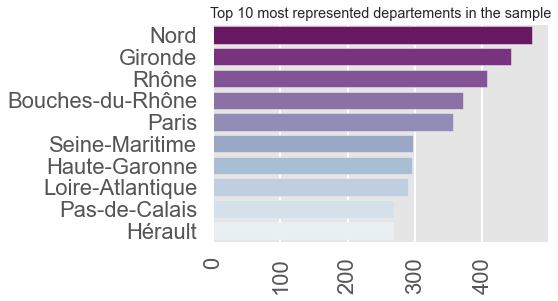

In [172]:
# Top 10 departements which are the most represented in the sample
sns_plot = sns.barplot(repr_dep.values[:10], list(repr_dep.index[:10]), palette='BuPu_r')
fig = sns_plot.get_figure()
plt.xticks(rotation=90)
plt.title('Top 10 most represented departements in the sample')
plt.show()
fig.savefig("project-24-files/fig_bar_most_dep.png")

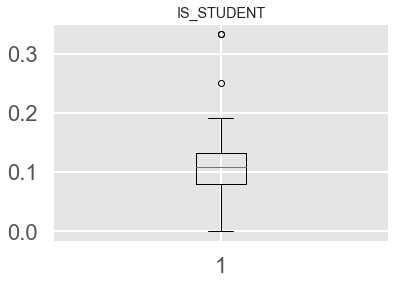

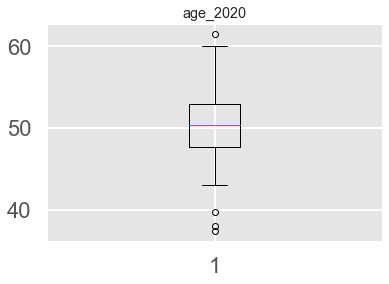

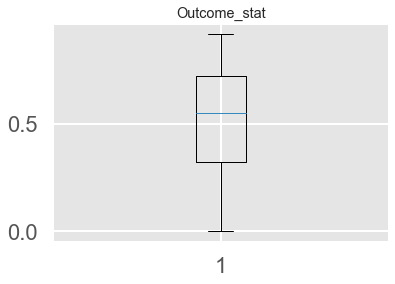

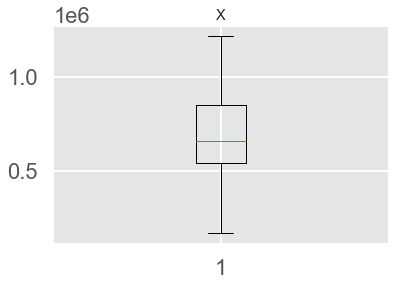

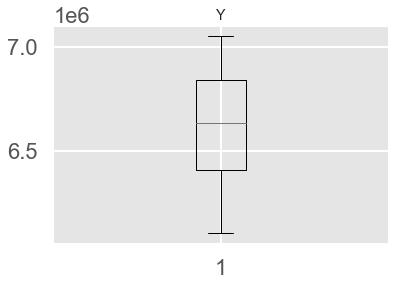

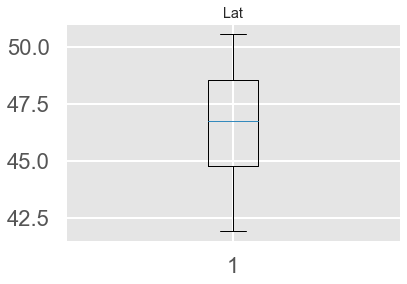

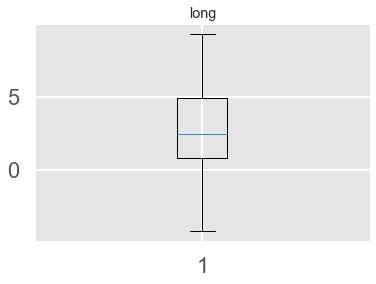

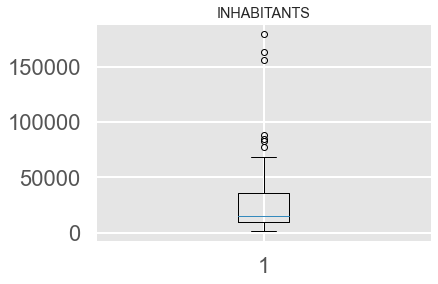

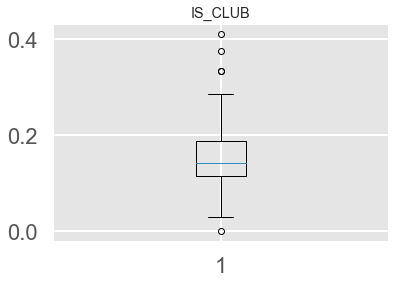

In [173]:
# boxplot analysis for numerical variables
for col_name in df_total.columns:
    if is_numeric_dtype(df_total[col_name]):
        plt.boxplot(df_total.groupby('Nom du département')[col_name].mean())
        plt.title(col_name)
        plt.show()
# Only care about INHABITANTS, Outcome_stat, IS_STUDENT, age_2020, IS_club

**distribution of categorical variables accross dep:**

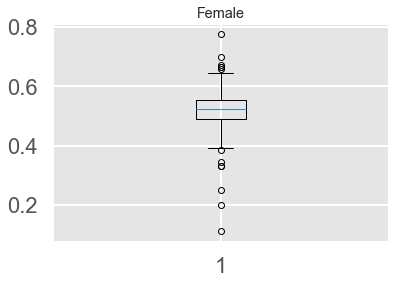

In [174]:
# visualize the distribution of categorical variables
# create a dataframe containing as col each category with the count for each dep
df_temp = df_total.groupby(['dep', 'sex'])['f_name'].count().unstack()
# obtain the proportions of men and women for each dep
df_temp2 = df_temp.div(df_temp.sum(axis=1), axis= 0)
# plot the distributions of women accross departements to view if sexes
# are evenly distributed accross departements
plt.boxplot(df_temp2.iloc[:, 0])
plt.title(df_temp.columns[0])
plt.show()

In [175]:
# generalize this technique to all categorical variables with less than 10
# different categories

In [176]:
# simple function to check if variable's type is categorical

def is_categorical(df_column):
    return df_column.dtype.name == 'category'

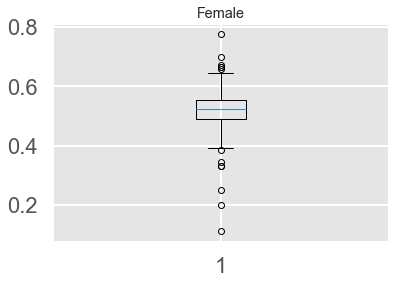

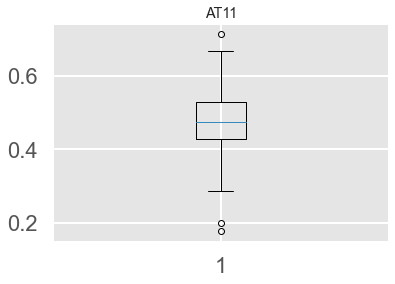

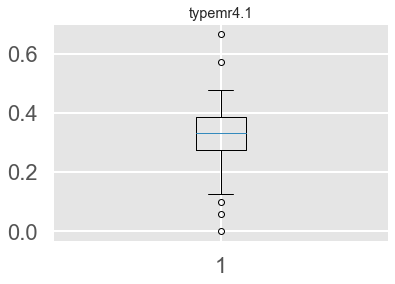

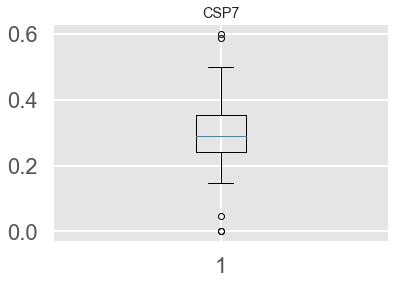

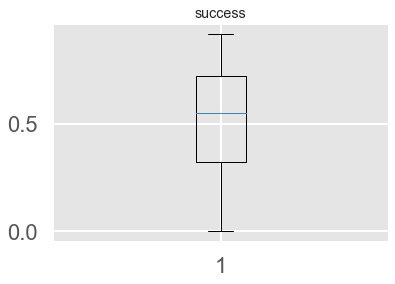

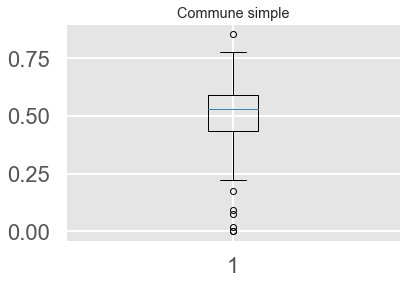

In [177]:
for col_name in df_total.columns:
    if (len(df_total[col_name].unique()) < 10) & (is_categorical(df_total[col_name])):
        df_temp = df_total.groupby(['dep', col_name])['f_name'].count().unstack()
        df_temp2 = df_temp.div(df_temp.sum(axis=1), axis= 0)
        # We want to find the most 
        # frequent category for each variable so that we boxplot it
        # we sum over all the proportions of each categories accross 
        # dep to find the most frequent category.
        # PRETTY ROUGH DECOMPOSE THE CODE TO UNDERSTAND BETTER THE PROCESS
        prop_most_freq_cat = df_temp2[df_temp2.sum().sort_values(ascending=False)[:1].index]
        plt.boxplot(prop_most_freq_cat.values)
        plt.title(prop_most_freq_cat.columns[0])
        plt.show()
 

## Regional Analysis

## Overview

In [178]:
# Find the region where the success rate was the highest
df_total.groupby('Nom de la région')['Outcome_stat'].mean().sort_values(ascending=False)

Nom de la région
Île-de-France                 0.850244
Bourgogne-Franche-Comté       0.773632
Normandie                     0.720703
Hauts-de-France               0.711438
Grand-Est                     0.694064
Pays de la Loire              0.689537
Centre-Val de Loire           0.598485
Auvergne-Rhône-Alpes          0.540808
Bretagne                      0.366864
Corse                         0.355556
Occitanie                     0.325301
Provence-Alpes-Côte d'Azur    0.248082
Nouvelle-Aquitaine            0.204103
Name: Outcome_stat, dtype: float64

In [179]:
# count how many sample individuals each region have
repr_reg = df_total.groupby('Nom de la région')['f_name'].count().sort_values(ascending=False) 
repr_reg

Nom de la région
Île-de-France                 1843
Auvergne-Rhône-Alpes          1213
Nouvelle-Aquitaine             975
Hauts-de-France                953
Occitanie                      913
Grand-Est                      876
Provence-Alpes-Côte d'Azur     782
Pays de la Loire               583
Normandie                      512
Bretagne                       507
Bourgogne-Franche-Comté        402
Centre-Val de Loire            396
Corse                           45
Name: f_name, dtype: int64

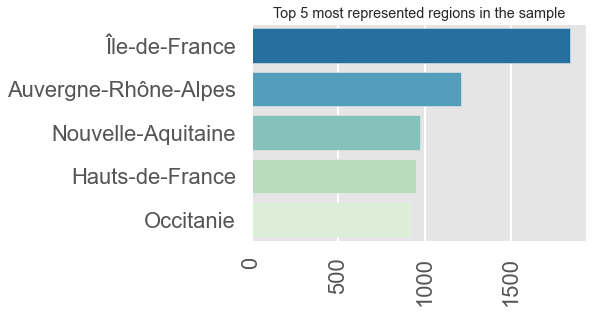

In [180]:
# Top 5 regions which are the most represented in the sample
sns.barplot(repr_reg.values[:5], list(repr_reg.index[:5]), palette='GnBu_r')
plt.xticks(rotation=90)
plt.title('Top 5 most represented regions in the sample')
plt.show()

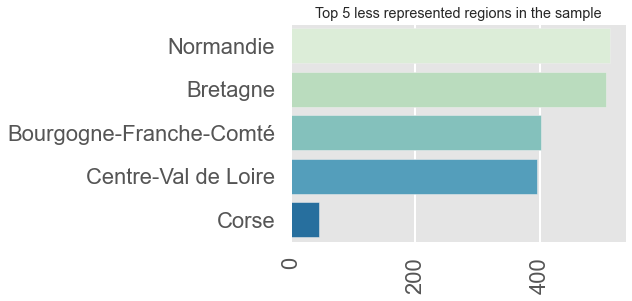

In [181]:
# Top 5 regions which are the less represented in the sample
sns.barplot(repr_reg.values[-5:], list(repr_reg.index[-5:]), palette='GnBu')
plt.xticks(rotation=90)
plt.title('Top 5 less represented regions in the sample')
plt.show()

### <u>Identification of the typical profile of an individual who responded postively to the marketing campaign in each region</u>:

In [182]:
# median age of individuals who responsed postively to the MC per reg
df_total[df_total['Outcome_stat']].groupby('Nom de la région')['age_2020'].median()

Nom de la région
Auvergne-Rhône-Alpes          40
Bourgogne-Franche-Comté       48
Bretagne                      38
Centre-Val de Loire           44
Corse                         38
Grand-Est                     46
Hauts-de-France               44
Normandie                     49
Nouvelle-Aquitaine            42
Occitanie                     40
Pays de la Loire              44
Provence-Alpes-Côte d'Azur    40
Île-de-France                 43
Name: age_2020, dtype: int32

In [183]:
# typical activity of an individual for which the MC succeed per reg
df_total[df_total['Outcome_stat']].groupby(['Nom de la région', 'act'])['f_name'].count()

Nom de la région            act 
Auvergne-Rhône-Alpes        AT11    391
                            AT12     45
                            AT21     64
                            AT22     84
                            AT24     26
                            AT25     46
Bourgogne-Franche-Comté     AT11    156
                            AT12     19
                            AT21     76
                            AT22     36
                            AT24     11
                            AT25     13
Bretagne                    AT11    105
                            AT12     17
                            AT21     12
                            AT22     27
                            AT24     10
                            AT25     15
Centre-Val de Loire         AT11    128
                            AT12     18
                            AT21     45
                            AT22     25
                            AT24      5
                            AT25     16
Corse  

## North - South Analysis

In [184]:
# from the regional visualization (below) we notice that the sucess rate is unevenly distributed among the "North"
# and the "South" of France. The success rate seems significantly low in the south of France in comparisson to the success rate
# in the North of France
# let's run a statistical test to verify this visual observation.

In [185]:
l_south_reg = ['Nouvelle-Aquitaine', 'Occitanie',"Provence-Alpes-Côte d'Azur", "Auvergne-Rhône-Alpes", "Corse"]

# let's compute the avg success rate in "southern" regions of France
avg_sr_south = df_total[df_total['Nom de la région'].isin(l_south_reg)]['Outcome_stat'].mean()

# computation of the avg success rate in "nothern" regions of France
avg_sr_north = df_total[~df_total['Nom de la région'].isin(l_south_reg)]['Outcome_stat'].mean()

print('Average success rate in "southern" regions of France:', avg_sr_south)
print('Average success rate in "northern" regions of France:', avg_sr_north)

Average success rate in "southern" regions of France: 0.34674134419551933
Average success rate in "northern" regions of France: 0.7177206851119895


In [186]:
# let's run a statistical student test for confirmation:
def run_student_test(sample_1, sample_2, alpha, feature):
    stat, p = ttest_ind(sample_1, sample_2)
    print('Statistics={stat:.{digits}f}, p={p:.{digits}f}'.format(stat=stat,
                                                                  digits=3,
                                                                  p=p))
    if p > alpha:
        print("There's no significant difference " +
              "of avg " + feature + " between the southern and nothern regions in our sample")
    else:
        print("There's a significant difference " +
              "of avg " + feature +" between the southern and nothern regions in our sample")

In [187]:
arr_otc_south = np.array(df_total[df_total['Nom de la région'].isin(l_south_reg)]['Outcome_stat'])
arr_otc_north = np.array(~df_total[df_total['Nom de la région'].isin(l_south_reg)]['Outcome_stat'])
run_student_test(arr_otc_south, arr_otc_north, 0.05, "success rate")

Statistics=-28.538, p=0.000
There's a significant difference of avg success rate between the southern and nothern regions in our sample


In [188]:
# Our t test confirms our visual observation. We observe a strong correlation. North or South localisation seems to coincide 
# with high or low success rate of the MC. Is this link causal ? We need to perform further analysis. In fact it is possible
# that there's a hidden variable wich is the true causal of the MC campaign and creates this correlation among North/South location
# and MC outcome. 
# Using our analysis in 2.2 we can focus on the variables we arleady know to explain significantly the Marketing Campaign 
# and verify their distribution accross the north and the south. For instance if we observe a significant difference in the
# distribution of age between North and South it is then possible that age of individuals truely explains the difference in 
# success rate and not the localisation. 

In [189]:
# run statistical test about the distribution of age between North and South of FRance in the sample.

In [190]:
arr_age_south = np.array(df_total[df_total['Nom de la région'].isin(l_south_reg)]['age_2020'])
arr_age_north = np.array(df_total[~df_total['Nom de la région'].isin(l_south_reg)]['age_2020'])
run_student_test(arr_age_south, arr_age_north, 0.05, 'age')

Statistics=1.919, p=0.055
There's no significant difference of avg age between the southern and nothern regions in our sample


In [191]:
# We observed in 2.2 that women were more likely to respond favorably to the MC than men; let's analyse the distribution of women
# accross north & south of france.
df_copy = df_total.copy()
# let's create boolean is_women to facilitate the making of the statistical test
df_copy['is_women'] = np.where(df_total['sex'] == 'Female', 1, 0)

arr_fem_south = np.array(df_copy[df_copy['Nom de la région'].isin(l_south_reg)]['is_women'])
arr_fem_north = np.array(df_copy[~df_copy['Nom de la région'].isin(l_south_reg)]['is_women'])
run_student_test(arr_fem_south, arr_fem_north, 0.05, 'proportion of female')

Statistics=-0.449, p=0.653
There's no significant difference of avg proportion of female between the southern and nothern regions in our sample


In [192]:
# After analyzing the age and sex distribution it seems that there's no hidden variables between the correlation of north/south 
# localisation and the success rate of the Marketing campaign.

In [193]:
############################################################################################
# Finally let's look at the distribution of the CSP ('Occupation_8') accross north and south

In [194]:
# quick look at the distribution of occupations in the South of our sample.
vc_occup_south = df_total[df_total['Nom de la région'].isin(l_south_reg)]['Occupation_8'].value_counts()
vc_occup_south

CSP7    1097
CSP8     690
CSP5     643
CSP4     557
CSP6     446
CSP3     313
CSP2     147
CSP1      35
Name: Occupation_8, dtype: int64

In [195]:
# quick look at the distribution of Occupations in the North in our sample
vc_occup_north = df_total[~df_total['Nom de la région'].isin(l_south_reg)]['Occupation_8'].value_counts() 
vc_occup_north

CSP7    1560
CSP8    1071
CSP5     981
CSP4     886
CSP6     751
CSP3     581
CSP2     198
CSP1      44
Name: Occupation_8, dtype: int64

In [196]:
# At a first glance we see that the order of frequency is the same in the north and in the south.
# let's investigate the proportions
print('Occupation distribution in the South of France based on our sample')
print(round(vc_occup_south / len(df_total[df_total['Nom de la région'].isin(l_south_reg)]), 2))
print('Occupation distribution in the North of France based on our sample')
print(round(vc_occup_north / len(df_total[~df_total['Nom de la région'].isin(l_south_reg)]), 2))

Occupation distribution in the South of France based on our sample
CSP7    0.28
CSP8    0.18
CSP5    0.16
CSP4    0.14
CSP6    0.11
CSP3    0.08
CSP2    0.04
CSP1    0.01
Name: Occupation_8, dtype: float64
Occupation distribution in the North of France based on our sample
CSP7    0.26
CSP8    0.18
CSP5    0.16
CSP4    0.15
CSP6    0.12
CSP3    0.10
CSP2    0.03
CSP1    0.01
Name: Occupation_8, dtype: float64


In [197]:
# distribution of Occupation is almost identical accross North-South in our sample.

Hence it seems that localisation between North and South is a determinant factor influencing the success rate of the Marketing Campaign.

### <u>Typical profile analysis</u>:

In [198]:
#let's finish by looking at the typical profile of an individual for which the Marketing campaign was sucessful 
# accross North/South localisation
# create a new variable bool for this purpose is_south = 1 if Individual is in the South of France, = 0 if in the North.
df_copy['is_south'] = np.where(df_copy['Nom de la région'].isin(l_south_reg), 1, 0)
print('median age of people who responded postively to the MC in South of France:', 
      df_copy['age_2020'][(df_copy['Outcome_stat'] == 1) & (df_copy['is_south']==1)].median())
print('median age of people who responded postively to the MC in North of France:', 
      df_copy['age_2020'][(df_copy['Outcome_stat'] == 1) & (df_copy['is_south']==0)].median())

print('\nTypical occupation of people responding postively to the MC, in the North:\n',
       df_copy['Occupation_8'][(df_copy['Outcome_stat']==1) & (df_copy['is_south']==0)].mode().str[:])
print('\nTypical occupation of people responding postively to the MC, in the South:\n',
       df_copy['Occupation_8'][(df_copy['Outcome_stat']==1) & (df_copy['is_south']==1)].mode().str[:])

median age of people who responded postively to the MC in South of France: 40.0
median age of people who responded postively to the MC in North of France: 44.0

Typical occupation of people responding postively to the MC, in the North:
 0    CSP8
Name: Occupation_8, dtype: object

Typical occupation of people responding postively to the MC, in the South:
 0    CSP8
Name: Occupation_8, dtype: object


In [199]:
def typical_profile_success_mc(var, cat, df):
    """
    var: which variable analyzed
    cat: True, analysis with the mode for categorical variables, False: median analysis for numerical variables
    df: dataframe used 
    """
    # var: which variable analyzed
    # cat: True, analysis with the mode for categorical variables, False: median analysis for numerical variables
    # df: dataframe used 
    if cat:
        print('\nTypical {} of people responding postively to the MC, in the North:\n'.format(var), 
               df[var][(df['Outcome_stat']==1) & (df['is_south']==0)].mode().str[:])
        print('\nTypical {} of people responding postively to the MC, in the South:\n'.format(var),
               df[var][(df['Outcome_stat']==1) & (df['is_south']==1)].mode().str[:])
        print(' ')
    else:
        print('\nMedian {} of people responding postively to the MC, in the North:\n'.format(var), 
               df[var][(df['Outcome_stat']==1) & (df['is_south']==0)].median())
        print('\nMedian {} of people responding postively to the MC, in the South:\n'.format(var),
               df[var][(df['Outcome_stat']==1) & (df['is_south']==1)].median())
        print(' ')

In [200]:
# example of usage of the new function
typical_profile_success_mc('sex', cat=True, df=df_copy)


Typical sex of people responding postively to the MC, in the North:
 0    Female
Name: sex, dtype: object

Typical sex of people responding postively to the MC, in the South:
 0    Female
Name: sex, dtype: object
 


In [201]:
num_var_to_analyze = ['age_2020'] 
cat_var_to_analyze = ['sex', 'contract', 'Occupation_8', 'act', 'Household_type']

In [202]:
# typical profile analysis for cat variables
for var in cat_var_to_analyze:
    typical_profile_success_mc(var, cat=True, df=df_copy)


Typical sex of people responding postively to the MC, in the North:
 0    Female
Name: sex, dtype: object

Typical sex of people responding postively to the MC, in the South:
 0    Female
Name: sex, dtype: object
 

Typical contract of people responding postively to the MC, in the North:
 0    contrat1|6
Name: contract, dtype: object

Typical contract of people responding postively to the MC, in the South:
 0    contrat1|6
Name: contract, dtype: object
 

Typical Occupation_8 of people responding postively to the MC, in the North:
 0    CSP8
Name: Occupation_8, dtype: object

Typical Occupation_8 of people responding postively to the MC, in the South:
 0    CSP8
Name: Occupation_8, dtype: object
 

Typical act of people responding postively to the MC, in the North:
 0    AT11
Name: act, dtype: object

Typical act of people responding postively to the MC, in the South:
 0    AT11
Name: act, dtype: object
 

Typical Household_type of people responding postively to the MC, in the North:


## Geographical representation of the results of the Marketing campaign accross departements

###  Departemental visualization

In [203]:
# file geojson with coordinates of french departements, enables to have 
# an overlay on the map representing the departements: 
# link to download the file: https://france-geojson.gregoiredavid.fr/repo/departements.geojson
dep_geo = 'project-24-files/departements.json'

In [204]:
df_folium = df_total.groupby('dep')['Outcome_stat'].mean()
# convert the serie to a dataframe object
df_folium = pd.DataFrame(df_folium.values, df_folium.index, 
                         columns=['avg_outc_per_dep'])
# change the type of index of df_folium to avoid complications
df_folium.index = df_folium.index.astype('object')

# add columns of data we want to visualize
df_folium['num_individuals_per_dep'] = df_total['dep'].value_counts()
df_folium['dep_code'] = df_folium.index

# convert zip_codes into string object so it matches the codes in the geojson file
df_folium['dep_code'] = df_folium['dep_code'].astype(str)

In [205]:
m = folium.Map(location=[46.7, 1.7], zoom_start=5)

folium.Choropleth(
    geo_data=dep_geo,
    data=df_folium,
    columns=['dep_code', 'num_individuals_per_dep'],
    key_on='feature.properties.code',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of individuals per departement in sample'
).add_to(m)

m




### Regional visualization

In [206]:
dep_geo = 'project-24-files/regions.json'

In [207]:
df_folium = df_total.groupby('reg')['Outcome_stat'].mean()
# convert the serie to a dataframe object
df_folium = pd.DataFrame(df_folium.values, df_folium.index, 
                         columns=['avg_outc_per_reg'])
# change the type of index of df_folium to avoid complications
df_folium.index = df_folium.index.astype('object')

# add columns of data we want to visualize
df_folium['num_individuals_per_reg'] = df_total['reg'].value_counts()
df_folium['reg_code'] = df_folium.index

# convert zip_codes into string object so it matches the codes in the geojson file
df_folium['reg_code'] = df_folium['reg_code'].astype(str)

<u>Map regional individuals distribution</u>:

In [208]:
m = folium.Map(location=[46.7, 1.7], zoom_start=5)

folium.Choropleth(
    geo_data=dep_geo,
    data=df_folium,
    columns=['reg_code', 'num_individuals_per_reg'],
    key_on='feature.properties.code',
    fill_color='GnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of individuals per reg in sample'
).add_to(m)

m

<u>Map suceess rate of MC per region</u>:


In [209]:
m = folium.Map(location=[46.7, 1.7], zoom_start=5)

folium.Choropleth(
    geo_data=dep_geo,
    data=df_folium,
    columns=['reg_code', 'avg_outc_per_reg'],
    key_on='feature.properties.code',
    fill_color='GnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Success rate of the Marketing Campaign per region'
).add_to(m)

m